## Homework #4. Exploratory Data Analysis
#### Author: `ANDRII VALENIA`
#### Intermediate result time spent on h/w (in minutes): `300`
#### Sentiment analysis time spent on h/w (in minutes): `200`
#### Topic categorization time spent on h/w (in minutes): `400`
#### User Feedback on ChatGPT Responses time spent on h/w (in minutes): `110`
#### Prompt Techniques time spent on h/w (in minutes): `70`
#### Self-review time spent on h/w (in minutes): `120`
#### Total time spent on h/w (in minutes): `1200`

#### Repo link: [https://github.com/Fybex/chatgpt-conversations-analysis](https://github.com/Fybex/chatgpt-conversations-analysis)

Data analysis is performed on the [dataset](https://www.kaggle.com/datasets/noahpersaud/89k-chatgpt-conversations/data) containing information about chatgpt conversations.

In [ ]:
%pip install -r requirements.txt

In [28]:
DATASET_PATH = "data/chatlogs-v2.jsonl"

### Loading data

In [1]:
import pandas as pd

df = pd.read_json(DATASET_PATH, lines=True)

In [2]:
df.head()

,post_number,system_message,conversation
0,[57],[],"[{'user': 'Anonymous', 'message': 'What is con..."
1,[53],[],"[{'user': 'Anonymous', 'message': 'write a poe..."
2,[56],[],"[{'user': 'Anonymous', 'message': 'What is con..."
3,[54],[],"[{'user': 'Anonymous', 'message': 'Can we use ..."
4,[51],[],"[{'user': 'Anonymous', 'message': 'como eu faç..."


Let's transform the data to a more convenient format where each row corresponds to a single conversation message.

In [3]:
rows = []
for _, row in df.iterrows():
    post_number = row["post_number"]
    conversation = row["conversation"]

    if isinstance(conversation, list):
        for message_order, message in enumerate(conversation):
            user = message["user"]
            text = message["message"]
            rows.append(
                {
                    "post_number": post_number[0],
                    "user": user,
                    "message": text,
                    "message_order": message_order,
                }
            )

df_expanded = pd.DataFrame(rows)
df_expanded.head()

,post_number,user,message,message_order
0,57,Anonymous,What is contrastive loss?,0
1,57,Chat GPT,Contrastive loss is a type of loss function th...,1
2,57,Anonymous,Do we need labels for contrastive learning?,2
3,57,Chat GPT,"In contrastive learning, it is not necessary t...",3
4,57,Anonymous,"Right, but we still need to know the differenc...",4


### General conversation analysis

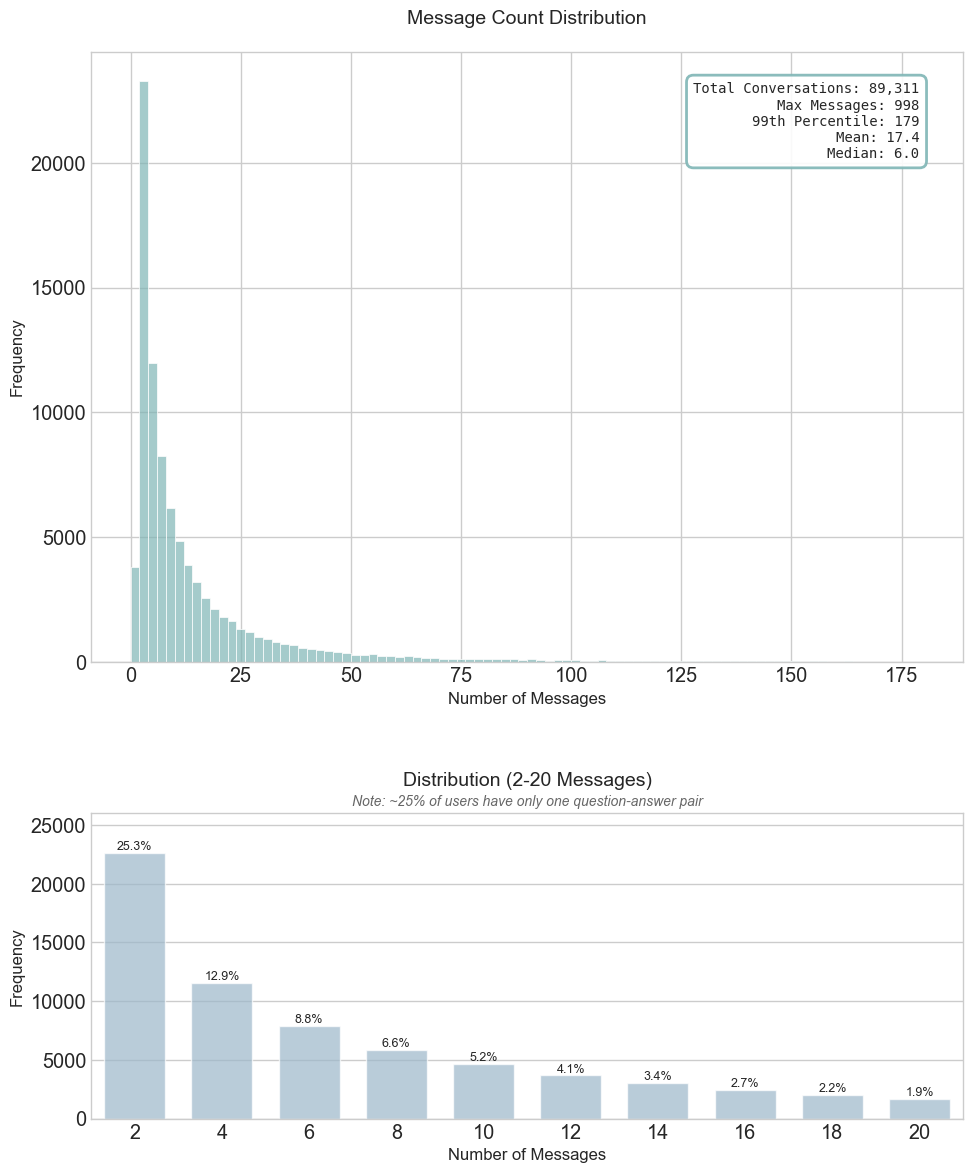

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="ticks", context="notebook", font_scale=1.3)
plt.style.use("seaborn-v0_8-whitegrid")

colors = ["#7FB5B5", "#95B8D1"]

df["message_count"] = df["conversation"].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), height_ratios=[2, 1])

max_percentile = np.percentile(df["message_count"], 99)
bins = np.arange(0, max_percentile + 2, 2)

# First plot
sns.histplot(
    data=df[df["message_count"] <= max_percentile],
    x="message_count",
    bins=bins,
    color=colors[0],
    alpha=0.7,
    ax=ax1,
    edgecolor="white",
    linewidth=0.5,
)

ax1.set_title("Message Count Distribution", fontsize=14, pad=20)
ax1.set_xlabel("Number of Messages", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)

stats_text = f"Total Conversations: {len(df):,}\n"
stats_text += f'Max Messages: {df["message_count"].max():,}\n'
stats_text += f"99th Percentile: {max_percentile:.0f}\n"
stats_text += f'Mean: {df["message_count"].mean():.1f}\n'
stats_text += f'Median: {df["message_count"].median():.1f}'

box = ax1.text(
    0.95,
    0.95,
    stats_text,
    transform=ax1.transAxes,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor=colors[0],
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
    zorder=5,
)

# Second plot
small_plot_size = 20
message_counts = range(2, small_plot_size + 1, 2)
counts = [len(df[df["message_count"] == count]) for count in message_counts]
total = len(df)

sns.barplot(
    x=list(message_counts), y=counts, color=colors[1], alpha=0.7, ax=ax2, width=0.7
)

for idx, (count, value) in enumerate(zip(message_counts, counts)):
    percentage = (value / total) * 100
    ax2.text(idx, value, f"{percentage:.1f}%", ha="center", va="bottom", fontsize=9)

ax2.set_ylim(0, max(counts) * 1.15)
ax2.set_title("Distribution (2-20 Messages)", fontsize=14, pad=20)

ax2.text(
    0.5,
    1.025,
    "Note: ~25% of users have only one question-answer pair",
    horizontalalignment="center",
    transform=ax2.transAxes,
    fontsize=10,
    style="italic",
    color="#666666",
)

ax2.set_xlabel("Number of Messages", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)


plt.tight_layout(h_pad=3)

plt.show()

I have left only an even number of messages on the second graph to avoid showing a small number of conversations that for some reason (e.g. ChatGPT did not respond) have only an odd number of messages.

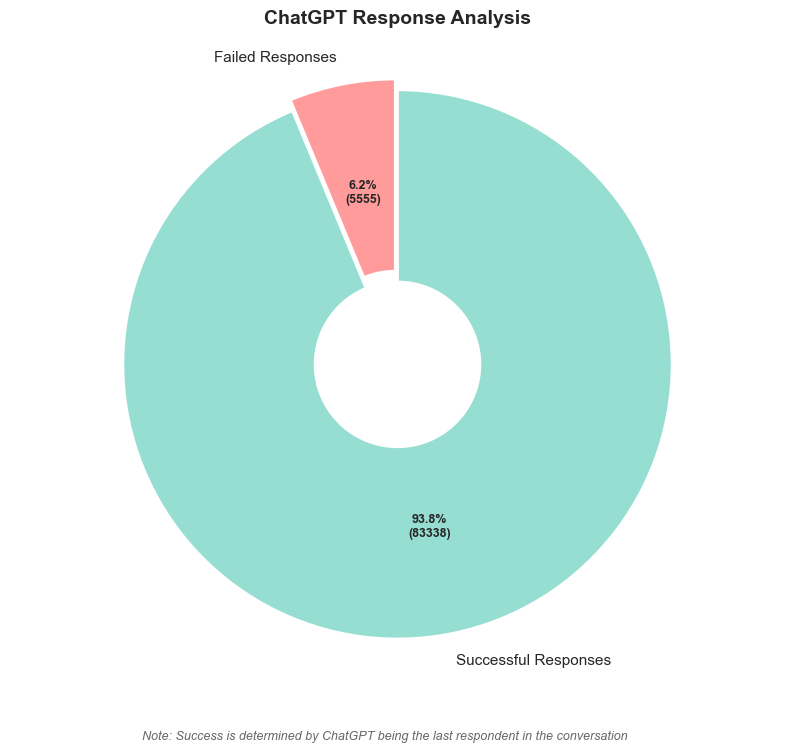

In [8]:
plt.style.use("seaborn-v0_8-whitegrid")
colors = ["#FF9B9B", "#96DED1"]


last_message_user = df_expanded.groupby("post_number").last()["user"]
chatgpt_responded = last_message_user == "Chat GPT"

chatgpt_responded_count = chatgpt_responded.sum()
chatgpt_failed_count = len(chatgpt_responded) - chatgpt_responded_count

plt.figure(figsize=(10, 8))

wedges, texts, autotexts = plt.pie(
    [chatgpt_failed_count, chatgpt_responded_count],
    labels=["Failed Responses", "Successful Responses"],
    colors=colors,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100.*sum([chatgpt_failed_count, chatgpt_responded_count]))})",
    startangle=90,
    explode=(0.02, 0.02),
    shadow=False,
    wedgeprops={"width": 0.7, "edgecolor": "white", "linewidth": 2},
)

plt.setp(autotexts, size=9, weight="bold")
plt.setp(texts, size=11)

plt.title("ChatGPT Response Analysis", pad=20, fontsize=14, fontweight="bold")

plt.figtext(
    0.5,
    0.02,
    "Note: Success is determined by ChatGPT being the last respondent in the conversation",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

plt.axis("equal")
plt.show()

Let's see more detailed analysis of when ChatGPT fails to respond.

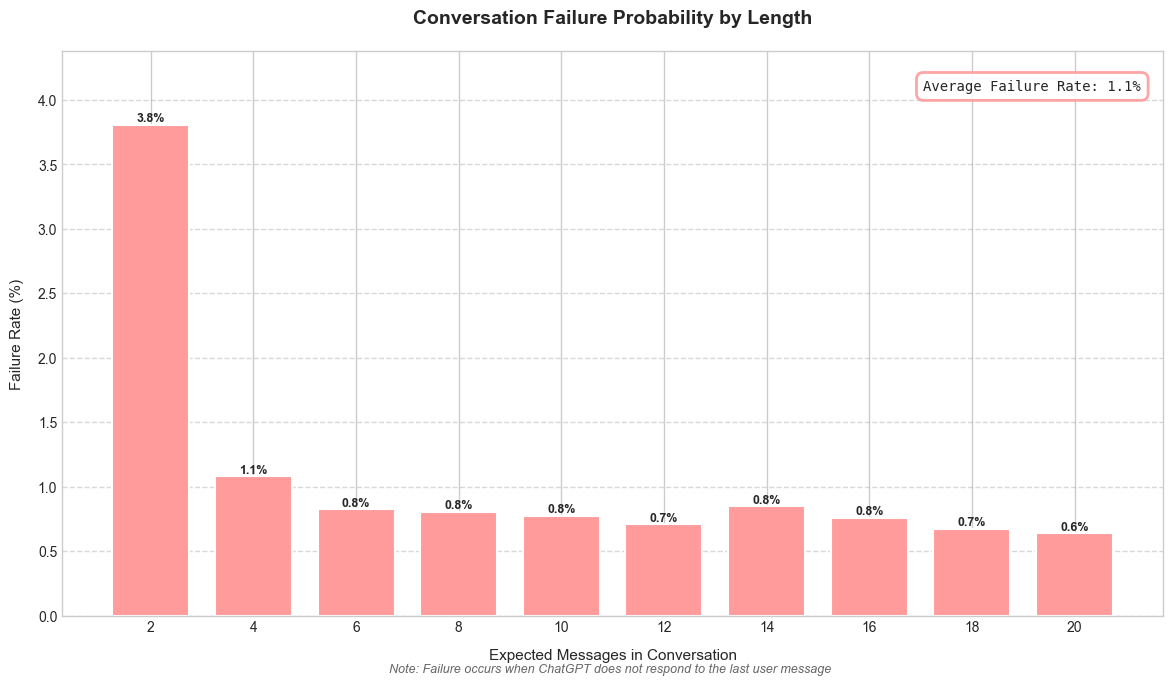

In [26]:
def calculate_failure_rates(df, max_messages=20):
    failure_rates = []
    message_numbers = range(2, max_messages + 1, 2)

    for target_length in message_numbers:
        total_conversations = len(df[df["message_count"] >= target_length - 1])
        failed_conversations = len(df[df["message_count"] == target_length - 1])

        if total_conversations > 0:
            failure_rate = (failed_conversations / total_conversations) * 100
        else:
            failure_rate = 0

        failure_rates.append(failure_rate)

    return message_numbers, failure_rates


message_numbers, failure_rates = calculate_failure_rates(df)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

bar_color = "#FF9B9B"

bars = plt.bar(
    message_numbers,
    failure_rates,
    color=bar_color,
    edgecolor="white",
    linewidth=1.5,
    width=1.5,
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
    )

plt.title(
    "Conversation Failure Probability by Length", fontsize=14, pad=20, fontweight="bold"
)

plt.xlabel("Expected Messages in Conversation", fontsize=11, labelpad=10)

plt.ylabel("Failure Rate (%)", fontsize=11, labelpad=10)

plt.grid(axis="y", linestyle="--", alpha=0.3, color="gray")

plt.xticks(message_numbers, fontsize=10)
plt.yticks(fontsize=10)

avg_failure_rate = np.mean(failure_rates)
plt.text(
    0.98,
    0.95,
    f"Average Failure Rate: {avg_failure_rate:.1f}%",
    transform=plt.gca().transAxes,
    ha="right",
    va="top",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor=bar_color,
        linewidth=2,
    ),
    fontsize=10,
    family="monospace",
    zorder=5,
)

plt.figtext(
    0.52,
    0.02,
    "Note: Failure occurs when ChatGPT does not respond to the last user message",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)
plt.ylim(0, max(failure_rates) * 1.15)

plt.tight_layout()
plt.show()

### Language analysis

Detecting the language of each message using `langdetect` library.

In [29]:
EXPANDED_CSV_PATH = "data/expanded_chatlogs.csv"

In [30]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from langdetect import detect, LangDetectException
import pandas as pd
from pathlib import Path
from time import time
from IPython.display import display
import ipywidgets as widgets


def safe_language_detect(text) -> str:
    try:
        return detect(str(text))
    except LangDetectException:
        return "unknown"


def process_batch(texts):
    return [safe_language_detect(text) for text in texts]


def create_batches(df, batch_size=100) -> list:
    return [
        df["message"].iloc[i : i + batch_size].tolist()
        for i in range(0, len(df), batch_size)
    ]


def detect_languages(df, batch_size=100, max_workers=12) -> list:
    batches = create_batches(df, batch_size)
    results = []
    total_batches = len(batches)

    progress = widgets.FloatProgress(
        value=0,
        min=0,
        max=total_batches,
        description="Processing:",
        bar_style="info",
        orientation="horizontal",
    )

    status_text = widgets.HTML(value="Starting...")
    display(widgets.VBox([progress, status_text]))

    start_time = time()

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_batch, batch) for batch in batches]

        for idx, future in enumerate(as_completed(futures)):
            batch_results = future.result()
            results.extend(batch_results)

            progress.value = idx + 1
            elapsed_time = time() - start_time
            est_total_time = elapsed_time / (idx + 1) * total_batches
            est_remaining = est_total_time - elapsed_time

            status_text.value = (
                f"Processed: {idx + 1}/{total_batches} batches | "
                f"Est. remaining: {est_remaining:.1f}s"
            )

    status_text.value = "Processing completed!"
    return results


if Path(EXPANDED_CSV_PATH).is_file():
    df_expanded = pd.read_csv(EXPANDED_CSV_PATH)
    print("Using existing CSV file.")
else:
    print("Detecting languages for each message...")
    df_expanded["language"] = detect_languages(df_expanded)
    df_expanded.to_csv(EXPANDED_CSV_PATH, index=False)

Using existing CSV file.


Took 51 minutes to detect language of each message using 12 threads on my M1 Pro.

In [33]:
df_expanded.shape

(1549630, 5)

In [34]:
df_expanded.sample(10)

,post_number,user,message,message_order,language
604835,56382,Chat GPT,行政行為の（職権）取消しとは、行政庁が違法行為をした場合、その行為を取り消すことを指します。...,169,ja
384343,67568,Chat GPT,Certainly! Here are some potential sub-article...,25,en
273085,73952,Chat GPT,Dans la phase de stratégie de la gestion de pr...,1,en
286359,73107,Anonymous,How does the new University of Austin https://...,78,en
299933,72296,Anonymous,> :/# wscat -c wss://react_314/ws error: conn...,14,en
1354206,17691,Anonymous,What version of DirectX do those assemblies al...,8,en
122625,83039,Chat GPT,"Sure, I can add obstacle avoidance feature to ...",61,en
991784,37352,Chat GPT,De maandelijkse lasten voor een huis in Frankr...,9,nl
132523,82392,Anonymous,"No more relationship woes."" This section descr...",18,en
1122592,30065,Chat GPT,"I'm sorry, but I cannot provide false or misle...",9,en


[0.55294118 0.82745098 0.78039216 1.        ]


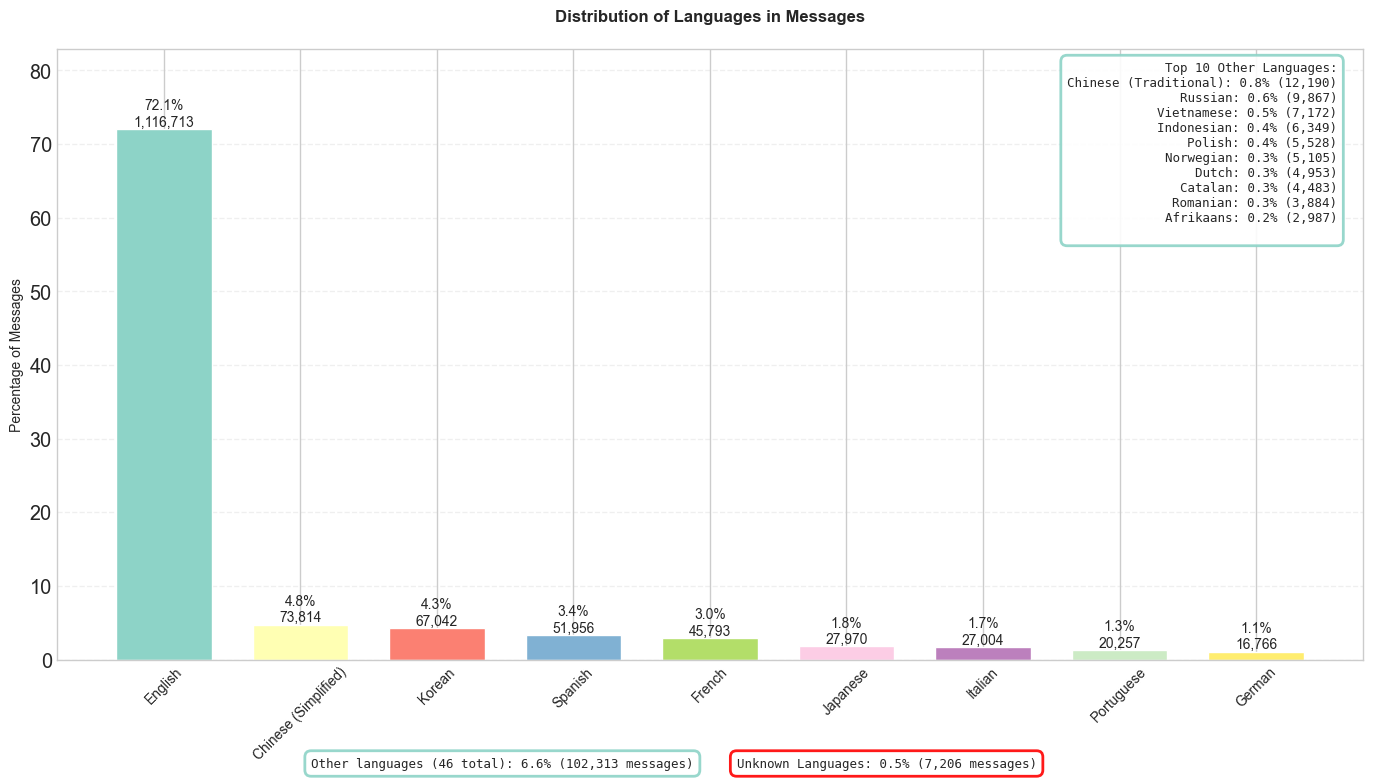

In [65]:
import pycountry


def get_country_name(code):
    if code == "zh-cn":
        return "Chinese (Simplified)"
    elif code == "zh-tw":
        return "Chinese (Traditional)"
    country_info = pycountry.languages.get(alpha_2=code)
    return country_info.name if country_info else code


def plot_language_distribution(df, threshold_percent=2):
    language_counts = df["language"].value_counts()
    total_messages = len(df)

    unknown_count = language_counts.get("unknown", 0)
    unknown_percentage = (unknown_count / total_messages) * 100

    percentages = (language_counts / total_messages) * 100
    percentages_sorted = percentages.sort_values(ascending=False)
    main_languages = percentages_sorted[percentages_sorted >= threshold_percent]
    other_languages = percentages_sorted[percentages_sorted < threshold_percent]

    plt.figure(figsize=(14, 8))

    main_ax = plt.gca()
    main_ax.bar(
        range(len(main_languages)),
        main_languages,
        color=plt.cm.Set3(np.linspace(0, 1, len(main_languages))),
        width=0.7,
    )

    first_color = plt.cm.Set3(np.linspace(0, 1, len(main_languages)))[0]
    print(first_color)

    for i, v in enumerate(main_languages):
        count = int(v * total_messages / 100)
        main_ax.text(
            i, v, f"{v:.1f}%\n{count:,}", ha="center", va="bottom", fontsize=10
        )

    main_ax.set_xticks(range(len(main_languages)))
    main_ax.set_xticklabels(
        [get_country_name(lang) for lang in main_languages.index],
        rotation=45,
        fontsize=10,
    )
    main_ax.set_ylabel("Percentage of Messages", fontsize=10)
    main_ax.set_ylim(0, max(main_languages) * 1.15)

    main_ax.set_title(
        "Distribution of Languages in Messages", pad=20, size=12, weight="bold"
    )

    main_ax.grid(axis="y", linestyle="--", alpha=0.3)

    other_pct = other_languages.sum()
    other_count = int(other_pct * total_messages / 100)

    top_10_text = "Top 10 Other Languages:\n"
    for lang, pct in other_languages[other_languages.index != "unknown"][:10].items():
        count = int(pct * total_messages / 100)
        top_10_text += f"{get_country_name(lang)}: {pct:.1f}% ({count:,})\n"

    main_ax.text(
        0.98,
        0.98,
        top_10_text,
        transform=main_ax.transAxes,
        bbox=dict(
            boxstyle="round,pad=0.5",
            facecolor="white",
            alpha=0.9,
            edgecolor="#8DD3C7",
            linewidth=2,
            mutation_scale=1.2,
        ),
        fontsize=9,
        family="monospace",
        verticalalignment="top",
        horizontalalignment="right",
    )

    unknown_text = (
        f"Unknown Languages: {unknown_percentage:.1f}% ({unknown_count:,} messages)"
    )
    plt.figtext(
        0.75,
        0.02,
        unknown_text,
        ha="right",
        va="bottom",
        bbox=dict(
            boxstyle="round,pad=0.5",
            facecolor="white",
            alpha=0.9,
            edgecolor="red",
            linewidth=2,
            mutation_scale=1.2,
        ),
        fontsize=9,
        family="monospace",
        verticalalignment="center",
        horizontalalignment="right",
    )

    summary_text = f"Other languages ({len(other_languages)} total): {other_pct:.1f}% ({other_count:,} messages)"
    plt.figtext(
        0.505,
        0.02,
        summary_text,
        ha="right",
        va="bottom",
        fontsize=9,
        family="monospace",
        bbox=dict(
            boxstyle="round,pad=0.5",
            facecolor="white",
            alpha=0.9,
            edgecolor="#8DD3C7",
            linewidth=2,
            mutation_scale=1.2,
        ),
    )

    plt.tight_layout()
    plt.show()


plot_language_distribution(df_expanded, threshold_percent=1)

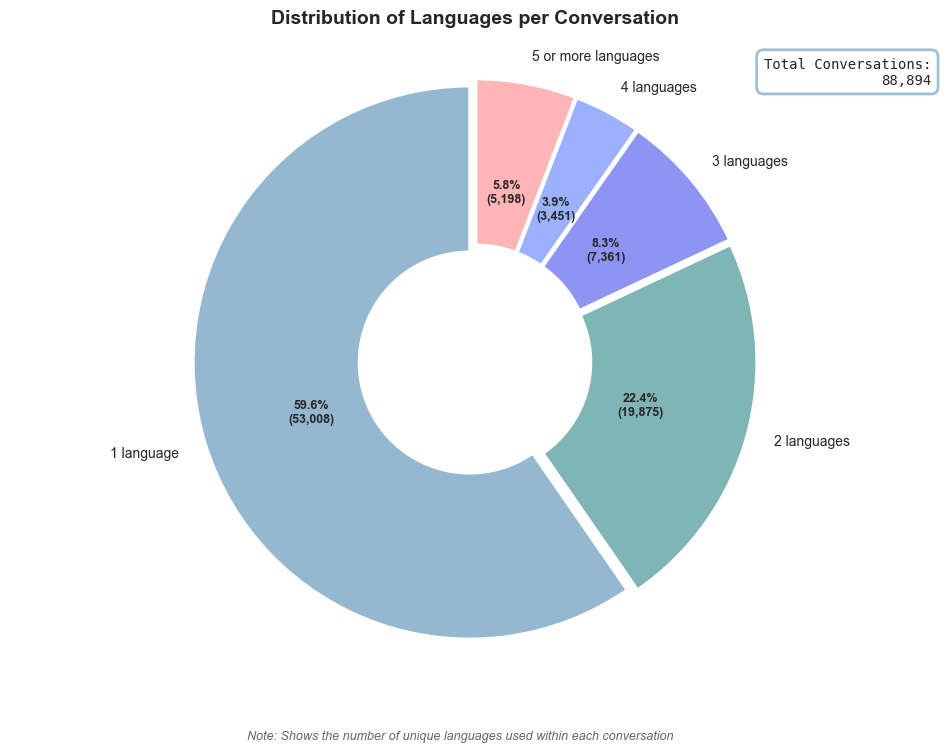

In [94]:
language_counts_per_conversation = (
    df_expanded.groupby("post_number")["language"].nunique().reset_index()
)
language_counts_per_conversation.columns = ["post_number", "unique_language_count"]
language_counts_per_conversation["unique_language_count"] = (
    language_counts_per_conversation[
        "unique_language_count"
    ].apply(lambda x: "5 or more" if x >= 5 else str(x))
)
language_count_distribution = (
    language_counts_per_conversation["unique_language_count"]
    .value_counts()
    .sort_index()
)

plt.figure(figsize=(12, 8))

colors = ["#95B8D1", "#7FB5B5", "#8E94F2", "#9BB1FF", "#FFB5B5"]

wedges, texts, autotexts = plt.pie(
    language_count_distribution,
    labels=[
        f'{count} language{"s" if count != "1" else ""}'
        for count in language_count_distribution.index
    ],
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100.*sum(language_count_distribution)):,})",
    colors=colors[: len(language_count_distribution)],
    startangle=90,
    explode=[0.02] * len(language_count_distribution),
    wedgeprops={"edgecolor": "white", "linewidth": 2, "width": 0.6},
)

plt.setp(autotexts, size=9, weight="bold")
plt.setp(texts, size=10)

plt.title("Distribution of Languages per Conversation", pad=20, size=14, weight="bold")

plt.figtext(
    0.5,
    0.02,
    "Note: Shows the number of unique languages used within each conversation",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

total_conversations = sum(language_count_distribution)
plt.text(
    1.65,
    1.1,
    f"Total Conversations:\n{total_conversations:,}",
    ha="right",
    va="top",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#95B8D1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
)

plt.axis("equal")
plt.show()

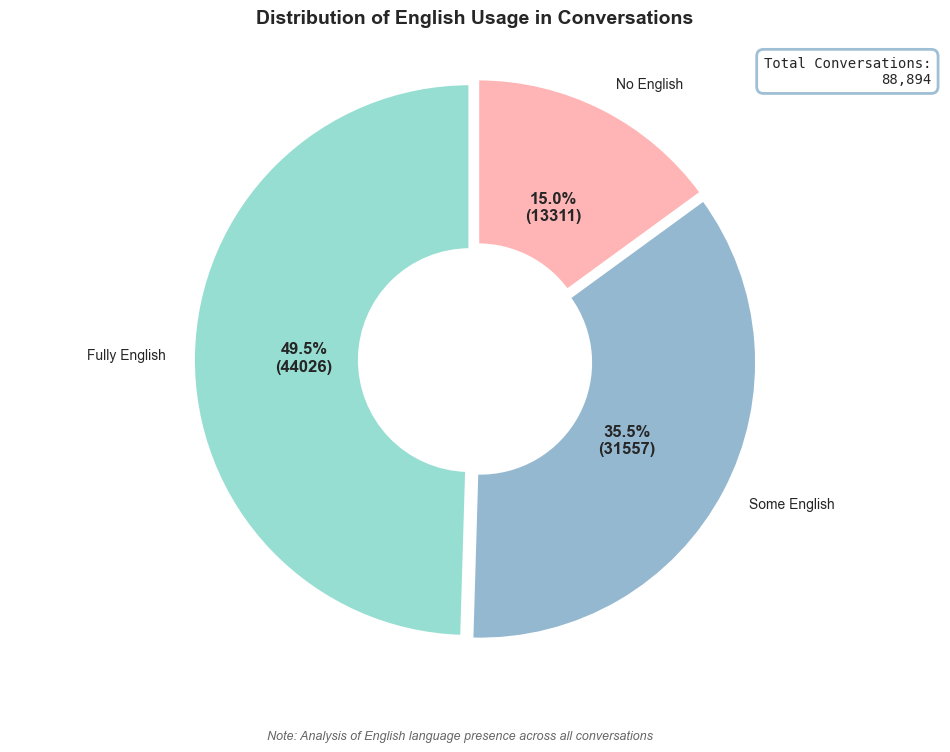

In [96]:
conversations = df_expanded.groupby("post_number")["language"].apply(list)
fully_english = sum(all(lang == "en" for lang in convo) for convo in conversations)
some_english = sum(
    any(lang == "en" for lang in convo) and not all(lang == "en" for lang in convo)
    for convo in conversations
)
no_english = sum(all(lang != "en" for lang in convo) for convo in conversations)

plt.figure(figsize=(12, 8))

colors = ["#96DED1", "#95B8D1", "#FFB5B5"]

wedges, texts, autotexts = plt.pie(
    [fully_english, some_english, no_english],
    labels=["Fully English", "Some English", "No English"],
    colors=colors,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100.*sum([fully_english, some_english, no_english]))})",
    startangle=90,
    explode=[0.02, 0.02, 0.02],
    wedgeprops={"edgecolor": "white", "linewidth": 2, "width": 0.6},
)

plt.setp(autotexts, size=9, weight="bold")
plt.setp(texts, size=10)

plt.title(
    "Distribution of English Usage in Conversations", pad=20, size=14, weight="bold"
)

plt.figtext(
    0.5,
    0.02,
    "Note: Analysis of English language presence across all conversations",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

total_conversations = sum([fully_english, some_english, no_english])
plt.text(
    1.65,
    1.1,
    f"Total Conversations:\n{total_conversations:,}",
    ha="right",
    va="top",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#95B8D1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
)

plt.setp(autotexts, size=12, weight="bold")

plt.axis("equal")
plt.show()

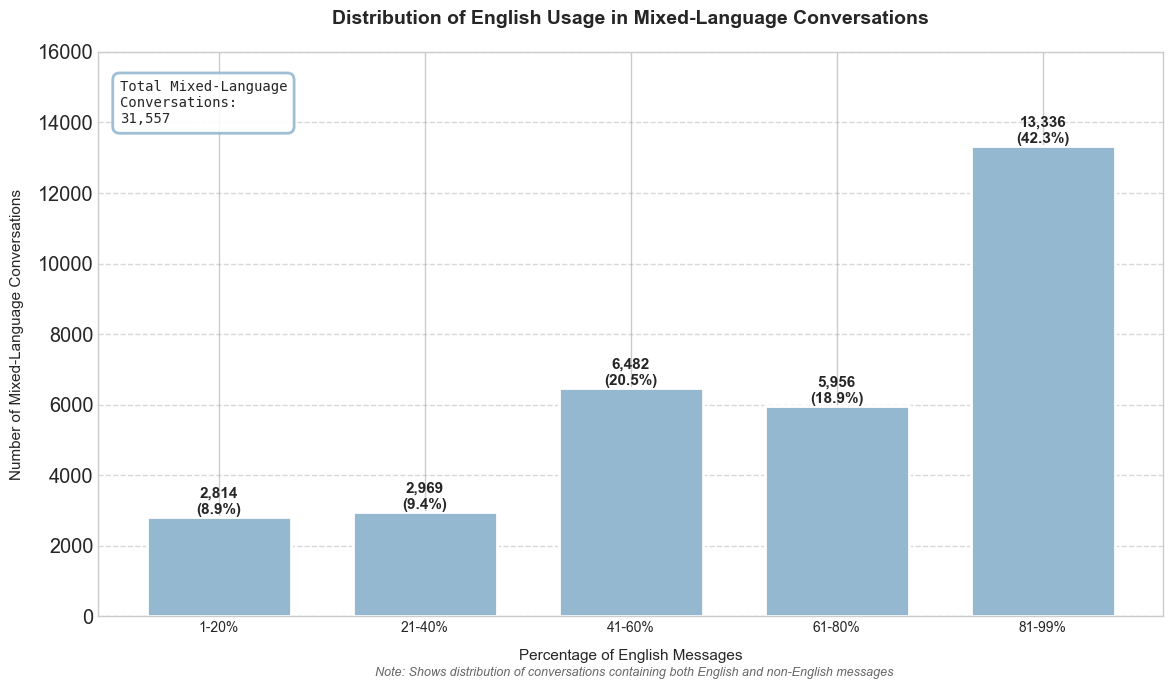

In [107]:
conversations = df_expanded.groupby("post_number")["language"].apply(list)
english_percentages = []

for convo in conversations:
    total_messages = len(convo)
    english_messages = sum(1 for lang in convo if lang == "en")
    percentage = (english_messages / total_messages) * 100 if total_messages > 0 else 0
    english_percentages.append(percentage)
mixed_percentages = [p for p in english_percentages if 0 < p < 100]

ranges = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]
range_counts = []
for low, high in ranges:
    count = sum(low < p <= high for p in mixed_percentages)
    range_counts.append(count)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(12, 7))

bars = plt.bar(
    range(len(ranges)),
    range_counts,
    color="#95B8D1",
    edgecolor="white",
    linewidth=2,
    width=0.7,
)

total_conversations = sum(range_counts)
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_conversations) * 100 if total_conversations > 0 else 0
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.5,
        f"{int(height):,}\n({percentage:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

plt.xticks(
    range(len(ranges)), ["1-20%", "21-40%", "41-60%", "61-80%", "81-99%"], fontsize=10
)
plt.ylabel("Number of Mixed-Language Conversations", fontsize=11, labelpad=10)
plt.xlabel("Percentage of English Messages", fontsize=11, labelpad=10)

plt.title(
    "Distribution of English Usage in Mixed-Language Conversations",
    pad=20,
    size=14,
    weight="bold",
)

plt.grid(axis="y", linestyle="--", alpha=0.3, color="gray")

total_mixed = len(mixed_percentages)
plt.text(
    0.02,
    0.95,
    f"Total Mixed-Language\nConversations:\n{total_mixed:,}",
    transform=plt.gca().transAxes,
    ha="left",
    va="top",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#95B8D1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
)

plt.figtext(
    0.54,
    0.015,
    "Note: Shows distribution of conversations containing both English and non-English messages",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

plt.ylim(0, max(range_counts) * 1.2)
plt.tight_layout()
plt.show()

In [108]:
df_temp = df_expanded.copy()
df_temp["next_user"] = df_temp.groupby("post_number")["user"].shift(-1)
df_temp["next_language"] = df_temp.groupby("post_number")["language"].shift(-1)

pairs_df = df_temp[
    (df_temp["user"] != "Chat GPT") & (df_temp["next_user"] == "Chat GPT")
].copy()

pairs_df = pairs_df[["post_number", "language", "next_language"]].rename(
    columns={"language": "user_language", "next_language": "chatgpt_language"}
)
pairs_df["pair_order"] = pairs_df.groupby("post_number").cumcount()
print(f"Total pairs: {pairs_df.shape[0]}")
for post_number, group in pairs_df.groupby("post_number"):
    if group["user_language"].nunique() > 1:
        print(group[group["user_language"] != "unknown"].head(5))
        break

Total pairs: 758239
         post_number user_language chatgpt_language  pair_order
1549455           58            nl               nl           0
1549457           58            en               en           1
1549459           58            en               en           2
1549461           58            en               en           3
1549463           58            en               en           4


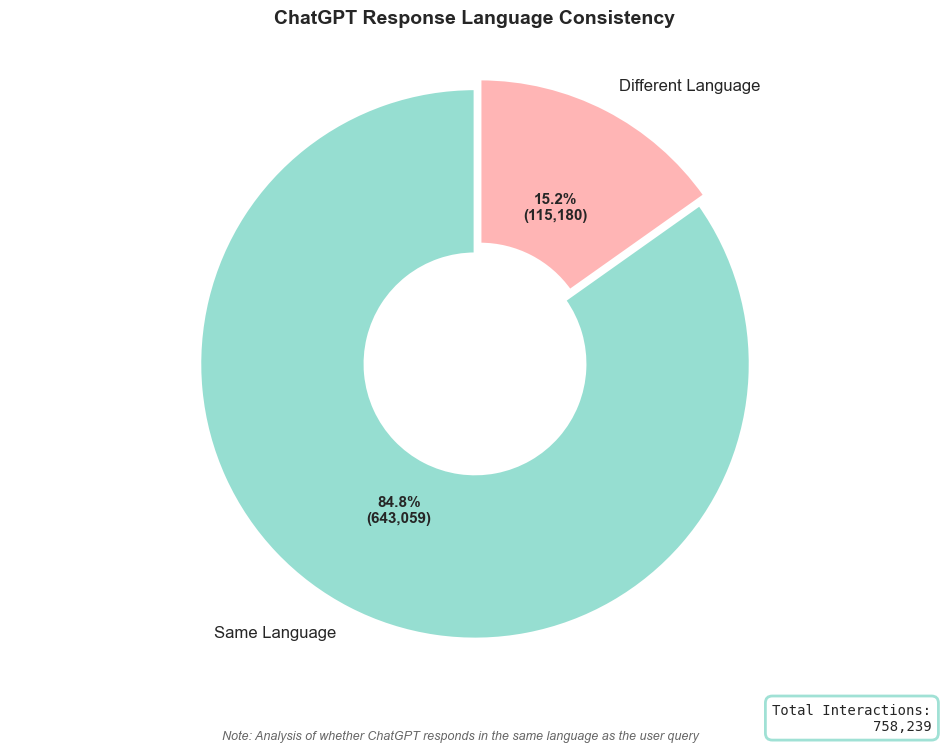

In [126]:
total_pairs = len(pairs_df)
matching_languages = (pairs_df["user_language"] == pairs_df["chatgpt_language"]).sum()
non_matching = total_pairs - matching_languages
percentage_matching = (matching_languages / total_pairs) * 100

plt.figure(figsize=(12, 8))

colors = ["#96DED1", "#FFB5B5"]

wedges, texts, autotexts = plt.pie(
    [matching_languages, non_matching],
    labels=["Same Language", "Different Language"],
    colors=colors,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100.*total_pairs):,})",
    startangle=90,
    explode=[0.02, 0.02],
    wedgeprops={"edgecolor": "white", "linewidth": 2, "width": 0.6},
)

plt.setp(autotexts, size=11, weight="bold")
plt.setp(texts, size=12)

plt.title("ChatGPT Response Language Consistency", pad=20, size=14, weight="bold")

plt.figtext(
    0.5,
    0.02,
    "Note: Analysis of whether ChatGPT responds in the same language as the user query",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

plt.text(
    1.65,
    -1.36,
    f"Total Interactions:\n{total_pairs:,}",
    ha="right",
    va="bottom",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#96DED1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
)

plt.axis("equal")
plt.show()

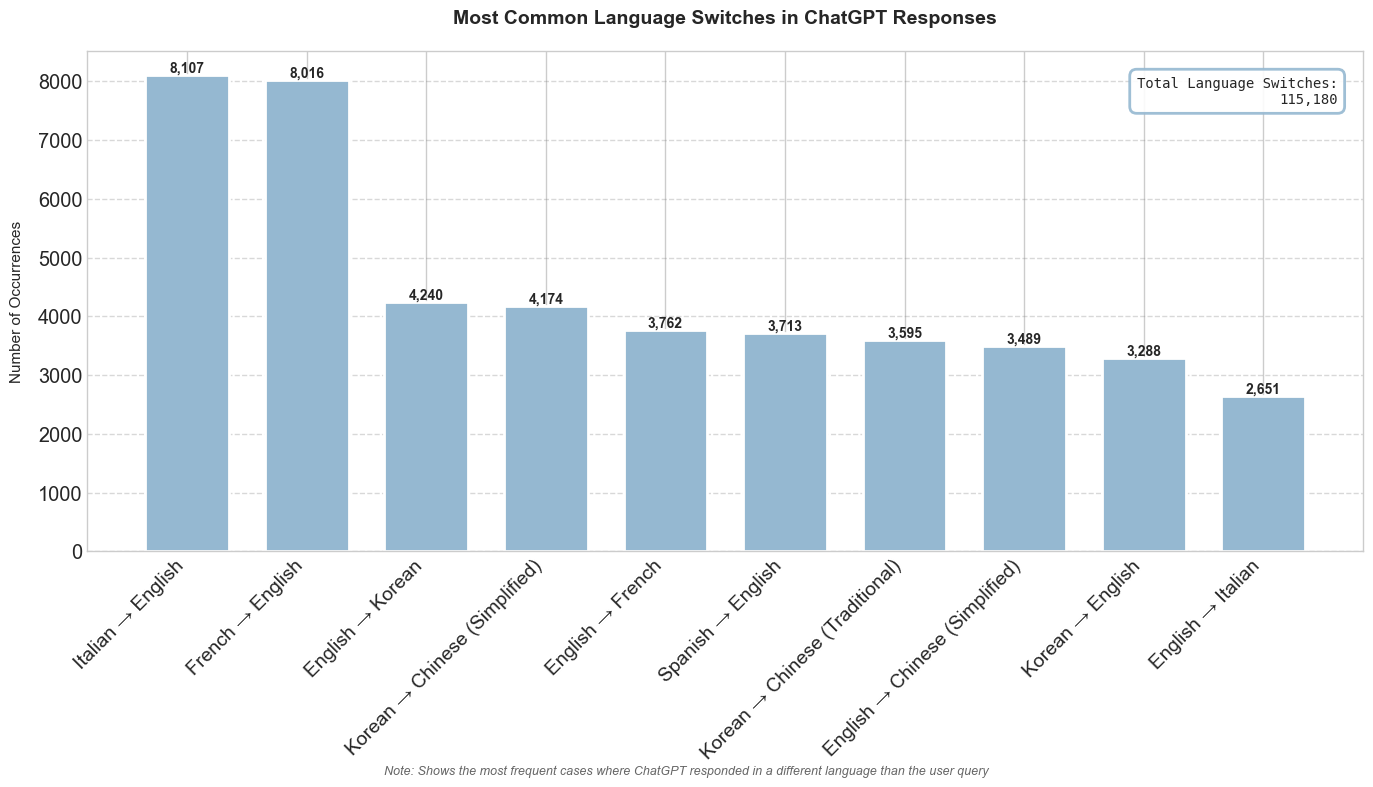

In [140]:
different_lang_responses = pairs_df[
    pairs_df["user_language"] != pairs_df["chatgpt_language"]
]
language_switches = (
    different_lang_responses.groupby(["user_language", "chatgpt_language"])
    .size()
    .reset_index()
)
language_switches.columns = ["User Language", "ChatGPT Response", "Count"]
language_switches = language_switches.sort_values("Count", ascending=False)
top_10_switches = language_switches.head(10)

plt.figure(figsize=(14, 8))

bars = plt.bar(
    range(len(top_10_switches)),
    top_10_switches["Count"],
    color="#95B8D1",
    edgecolor="white",
    linewidth=2,
    width=0.7,
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.xticks(
    range(len(top_10_switches)),
    [
        f'{get_country_name(row["User Language"])} → {get_country_name(row["ChatGPT Response"])}'
        for _, row in top_10_switches.iterrows()
    ],
    rotation=45,
    fontsize=14,
    ha="right",
)

plt.title(
    "Most Common Language Switches in ChatGPT Responses", pad=20, size=14, weight="bold"
)
plt.ylabel("Number of Occurrences", fontsize=11, labelpad=10)

plt.grid(axis="y", linestyle="--", alpha=0.3, color="gray")

total_switches = different_lang_responses.shape[0]
plt.text(
    0.98,
    0.95,
    f"Total Language Switches:\n{total_switches:,}",
    transform=plt.gca().transAxes,
    ha="right",
    va="top",
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#95B8D1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
)

plt.figtext(
    0.5,
    0.015,
    "Note: Shows the most frequent cases where ChatGPT responded in a different language than the user query",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

plt.tight_layout()
plt.show()

ChatGPT tends to switch to English quite often.

**Note**: it needs more research on why it does that. Maybe most of the cases is that user asks to write response in English or other languages to which ChatGPT switches.

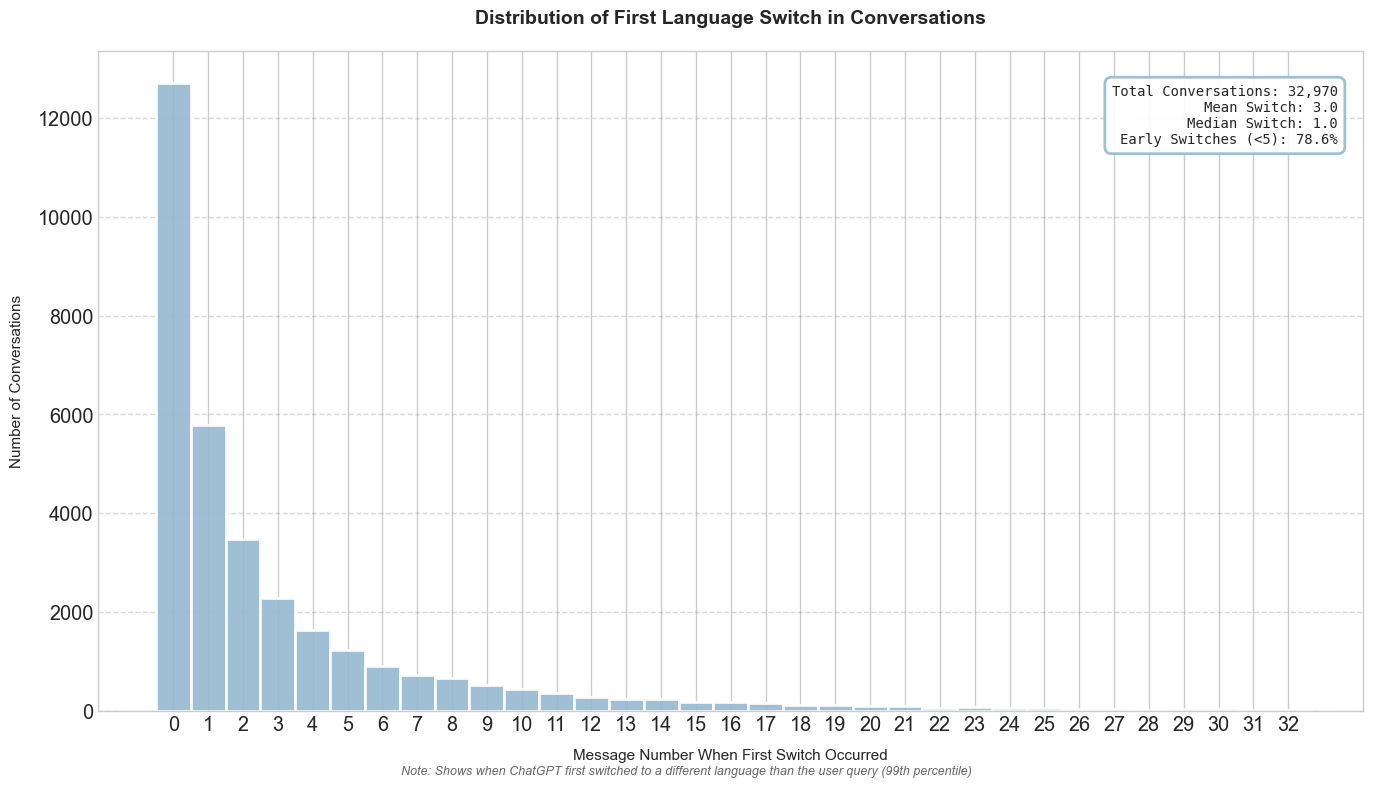

In [142]:
first_mismatches = different_lang_responses.groupby("post_number")["pair_order"].min()
filtered_mismatches = first_mismatches[
    first_mismatches <= np.percentile(first_mismatches, 99)
]

mean_switch = filtered_mismatches.mean()
median_switch = filtered_mismatches.median()
total_samples = len(filtered_mismatches)
early_switches_pct = (
    len(filtered_mismatches[filtered_mismatches < 5]) / total_samples * 100
)

fig, ax = plt.subplots(figsize=(14, 8))

max_message = int(np.ceil(filtered_mismatches.max()))
bins = np.arange(0, max_message + 2) - 0.5

n, bins, patches = plt.hist(
    filtered_mismatches,
    bins=bins,
    color="#95B8D1",
    edgecolor="white",
    linewidth=2,
    alpha=0.9,
)

plt.grid(axis="y", linestyle="--", alpha=0.3, color="gray")

plt.title(
    "Distribution of First Language Switch in Conversations",
    fontsize=14,
    pad=20,
    weight="bold",
)
plt.xlabel("Message Number When First Switch Occurred", fontsize=11, labelpad=10)
plt.ylabel("Number of Conversations", fontsize=11, labelpad=10)

stats_text = (
    f"Total Conversations: {total_samples:,}\n"
    f"Mean Switch: {mean_switch:.1f}\n"
    f"Median Switch: {median_switch:.1f}\n"
    f"Early Switches (<5): {early_switches_pct:.1f}%"
)
plt.text(
    0.98,
    0.95,
    stats_text,
    transform=ax.transAxes,
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#95B8D1",
        linewidth=2,
        mutation_scale=1.2,
    ),
    va="top",
    ha="right",
    fontsize=10,
    family="monospace",
)

plt.figtext(
    0.5,
    0.015,
    "Note: Shows when ChatGPT first switched to a different language than the user query (99th percentile)",
    ha="center",
    fontsize=9,
    style="italic",
    color="#666666",
)

plt.xticks(np.arange(0, max_message + 1, 1))

plt.tight_layout()
plt.show()

### Sentiment Analysis

In [143]:
from textblob import TextBlob
from tqdm.auto import tqdm


def process_text(text):
    try:
        if not isinstance(text, str) or len(text.strip()) < 3:
            return np.nan
        return TextBlob(text).sentiment.polarity
    except Exception as e:
        print(f"Error processing text: {str(e)[:100]}")
        return np.nan


def process_batch(texts):
    return [process_text(text) for text in texts]


def detect_polarity(df, message_column="message", batch_size=1000, max_workers=12):
    if df.empty:
        return []

    english_mask = df["language"] == "en"
    messages = df[english_mask][message_column].values
    total_messages = len(messages)

    if total_messages == 0:
        return [np.nan] * len(df)

    batch_indices = np.array_split(
        np.arange(total_messages),
        min(max_workers * 4, max(1, total_messages // batch_size)),
    )
    batches = [messages[idx] for idx in batch_indices]

    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_batch, batch) for batch in batches]

        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Analyzing sentiment (English only)",
            unit="batch",
        ):
            try:
                batch_results = future.result()
                results.extend(batch_results)
            except Exception as e:
                print(f"Error processing batch: {str(e)[:100]}")
                failed_batch_size = len(batch_indices[len(results) // batch_size])
                results.extend([np.nan] * failed_batch_size)

    final_results = np.full(len(df), np.nan)
    english_indices = np.where(english_mask)[0]
    assert len(results) == len(english_indices), "Results mismatch"
    final_results[english_indices] = results

    return final_results.tolist()


if "polarity" in df_expanded.columns:
    print("Using cached polarity scores.")
else:
    print("Calculating polarities...")
    df_expanded["polarity"] = detect_polarity(df_expanded)

    print("Saving results to CSV...")
    df_expanded.to_csv(EXPANDED_CSV_PATH, index=False)

Calculating polarities...


Analyzing sentiment (English only):   0%|          | 0/48 [00:01<?, ?batch/s]

Saving results to CSV...


In [146]:
df_expanded[df_expanded["language"] == "en"].head(10)

,post_number,user,message,message_order,language,polarity
1379,17808,Anonymous,let's deploy the model using laravel and googl...,178,en,0.291667
1380,17808,Chat GPT,Certainly! Here is an overview of the steps yo...,179,en,0.000000
1381,17808,Anonymous,"let's use github, cloud build and cloud run to...",180,en,0.083333
1382,17808,Chat GPT,Certainly! Here is an overview of the steps yo...,181,en,0.000000
1383,17808,Anonymous,write boilerplate code to leverage cloud build...,182,en,0.120000
1384,17808,Chat GPT,Certainly! Here is an example of how you can u...,183,en,0.183333
1385,17808,Anonymous,sounds good. let's work on missing pieces.,184,en,0.106863
1386,17808,Chat GPT,Certainly! I'm glad to help. Here is a list of...,185,en,0.004545
1387,17808,Anonymous,what language would you use for this system in...,186,en,0.000000
1388,17808,Chat GPT,There are many programming languages that you ...,187,en,-0.125000


In [148]:
def get_polarity_category(polarity):
    if pd.isna(polarity):
        return None
    elif polarity <= -0.5:
        return "Very Negative"
    elif -0.5 < polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    elif 0 < polarity < 0.5:
        return "Positive"
    else:  # polarity >= 0.5
        return "Very Positive"


df_expanded["sentiment_category"] = df_expanded["polarity"].apply(get_polarity_category)


def get_polarity_summary(df):
    return (
        df["sentiment_category"]
        .dropna()
        .value_counts()
        .reindex(["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"])
    )


polarity_summary = get_polarity_summary(df_expanded)
user_polarity = get_polarity_summary(df_expanded[df_expanded["user"] == "Anonymous"])
gpt_polarity = get_polarity_summary(df_expanded[df_expanded["user"] == "Chat GPT"])

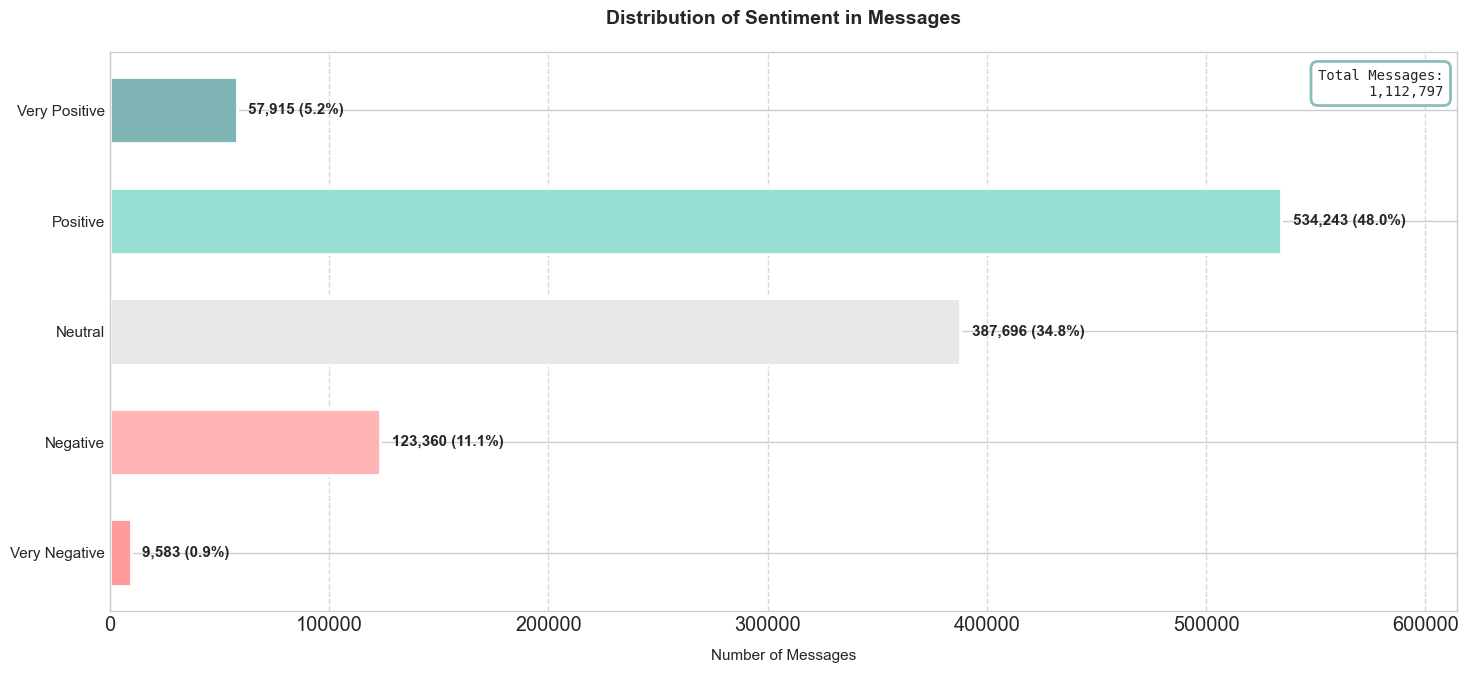

In [164]:
plt.figure(figsize=(15, 7))

values = polarity_summary.to_numpy()
total = np.sum(values)
y_pos = np.arange(len(polarity_summary))

colors = ["#FF9B9B", "#FFB5B5", "#E8E8E8", "#96DED1", "#7FB5B5"]

bars = plt.barh(y_pos, values, color=colors, edgecolor="white", linewidth=2, height=0.6)

for i, bar in enumerate(bars):
    width = bar.get_width()
    percentage = (width / total) * 100
    plt.text(
        width + (max(values) * 0.01),
        bar.get_y() + bar.get_height() / 2,
        f"{int(width):,} ({percentage:.1f}%)",
        va="center",
        fontsize=11,
        fontweight="bold",
    )

plt.yticks(y_pos, polarity_summary.index, fontsize=11)
plt.xlabel("Number of Messages", fontsize=11, labelpad=10)

plt.title("Distribution of Sentiment in Messages", fontsize=14, pad=20, weight="bold")

plt.grid(True, axis="x", alpha=0.3, linestyle="--", color="gray")
plt.xlim(0, max(values) * 1.15)

plt.text(
    0.99,
    0.97,
    f"Total Messages:\n{int(total):,}",
    transform=plt.gca().transAxes,
    bbox=dict(
        boxstyle="round,pad=0.5",
        facecolor="white",
        alpha=0.9,
        edgecolor="#7FB5B5",
        linewidth=2,
        mutation_scale=1.2,
    ),
    fontsize=10,
    family="monospace",
    ha="right",
    va="top",
)

plt.tight_layout()
plt.show()

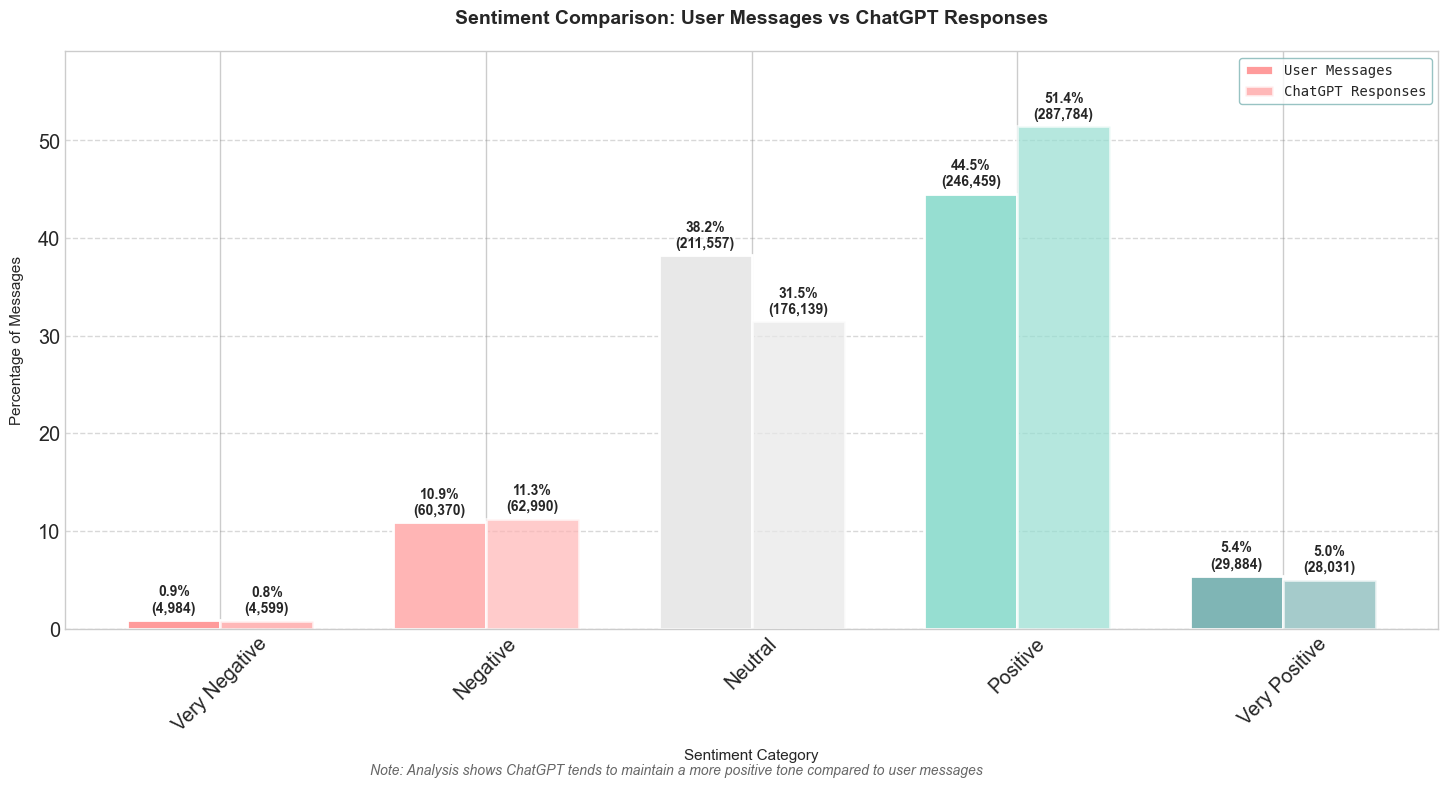

In [179]:
plt.figure(figsize=(15, 8))

categories = list(user_polarity.index)
x = np.arange(len(categories))
width = 0.35

user_values = user_polarity.to_numpy()
gpt_values = gpt_polarity.to_numpy()

user_total = np.sum(user_values)
gpt_total = np.sum(gpt_values)
user_percentages = [v / user_total * 100 for v in user_values]
gpt_percentages = [v / gpt_total * 100 for v in gpt_values]

colors = ["#FF9B9B", "#FFB5B5", "#E8E8E8", "#96DED1", "#7FB5B5"]

bars1 = plt.bar(
    x - width / 2,
    user_percentages,
    width,
    label="User Messages",
    color=colors,
    edgecolor="white",
    linewidth=2,
)
bars2 = plt.bar(
    x + width / 2,
    gpt_percentages,
    width,
    label="ChatGPT Responses",
    color=colors,
    edgecolor="white",
    linewidth=2,
    alpha=0.7,
)


def add_labels(bars, raw_values):
    for bar, raw_val in zip(bars, raw_values):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.5,
            f"{height:.1f}%\n({int(raw_val):,})",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )


add_labels(bars1, user_values)
add_labels(bars2, gpt_values)

plt.xlabel("Sentiment Category", fontsize=11, labelpad=10)
plt.ylabel("Percentage of Messages", fontsize=11, labelpad=10)
plt.title(
    "Sentiment Comparison: User Messages vs ChatGPT Responses",
    pad=20,
    size=14,
    weight="bold",
)
plt.xticks(x, categories, rotation=45)
plt.legend(
    fontsize=10,
    bbox_to_anchor=(0.85, 1),
    loc="upper left",
    frameon=True,
    facecolor='white',
    edgecolor='#7FB5B5',
    prop={'family': 'monospace', 'size': 10}
)
plt.grid(axis="y", linestyle="--", alpha=0.3, color="gray")
plt.ylim(0, max(user_percentages + gpt_percentages) * 1.15)

plt.figtext(
    0.46,
    0.015,
    "Note: Analysis shows ChatGPT tends to maintain a more positive tone compared to user messages",
    ha="center",
    fontsize=10,
    style="italic",
    color="#666666",
)

plt.tight_layout()
plt.show()

In [180]:
df_temp = df_expanded.copy()
df_temp["next_user"] = df_temp.groupby("post_number")["user"].shift(-1)
df_temp["next_polarity"] = df_temp.groupby("post_number")["polarity"].shift(-1)
pairs_df = df_temp[
    (df_temp["user"] == "Anonymous") & (df_temp["next_user"] == "Chat GPT")
].copy()
pairs_df = pairs_df.rename(
    columns={"polarity": "user_polarity", "next_polarity": "gpt_polarity"}
)
pairs_df.sample(10)
del df_temp

In [181]:
pairs_df["user_polarity_cat"] = pairs_df["user_polarity"].apply(get_polarity_category)
pairs_df["gpt_polarity_cat"] = pairs_df["gpt_polarity"].apply(get_polarity_category)

response_patterns = (
    pd.crosstab(
        pairs_df["user_polarity_cat"], pairs_df["gpt_polarity_cat"], normalize="index"
    )
    * 100
)
response_patterns

gpt_polarity_cat,Negative,Neutral,Positive,Very Negative,Very Positive
user_polarity_cat,,,,,
Negative,21.204349,27.108695,46.786837,1.130658,3.769461
Neutral,10.580869,34.384053,50.730441,0.785309,3.519328
Positive,9.619650,31.297511,52.366616,0.703056,6.013167
Very Negative,25.081860,27.090155,38.965291,5.741105,3.121589
Very Positive,7.539248,17.962760,64.863089,0.397955,9.236948


<Figure size 1200x1000 with 0 Axes>

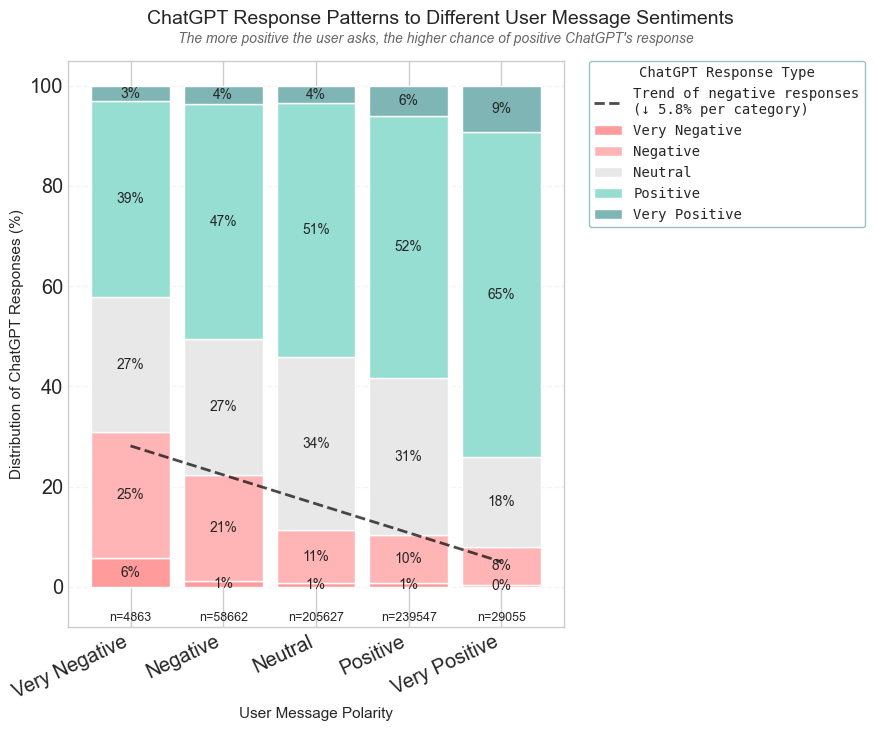

In [195]:
polarity_order = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
response_patterns = response_patterns.reindex(index=polarity_order)
response_patterns = response_patterns.reindex(columns=polarity_order)

plt.figure(figsize=(12, 10))

colors = ["#FF9B9B", "#FFB5B5", "#E8E8E8", "#96DED1", "#7FB5B5"]
ax = response_patterns.plot(kind="bar", stacked=True, color=colors, width=0.85)

negative_responses = response_patterns["Negative"] + response_patterns["Very Negative"]
x = np.arange(len(polarity_order))
z = np.polyfit(x, negative_responses, 1)
p = np.poly1d(z)
plt.plot(
    x,
    p(x),
    "--",
    linewidth=2,
    color="black",
    alpha=0.7,
    label=f"Trend of negative responses\n(↓ {abs(z[0]):.1f}% per category)",
)
plt.title(
    "ChatGPT Response Patterns to Different User Message Sentiments",
    fontsize=14,
    x=0.75,
    y=1.05,
)
plt.suptitle(
    "The more positive the user asks, the higher chance of positive ChatGPT's response",
    fontsize=10,
    style="italic",
    color="#666666",
    x=0.7,
    y=0.94,
)

plt.xlabel("User Message Polarity", fontsize=11)
plt.ylabel("Distribution of ChatGPT Responses (%)", fontsize=11)

plt.xticks(rotation=25, ha="right")

for c in ax.containers:
    ax.bar_label(c, fmt="%.0f%%", label_type="center", fontsize=10)

plt.legend(
    title="ChatGPT Response Type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0,
    frameon=True,
    facecolor='white',
    edgecolor='#7FB5B5',
    prop={'family': 'monospace', 'size': 10},
    title_fontproperties={'family': 'monospace', 'size': 10}
)

for i, user_pol in enumerate(polarity_order):
    total = len(pairs_df[pairs_df["user_polarity_cat"] == user_pol])
    plt.text(i, -5, f"n={total}", ha="center", va="top", fontsize=9)

plt.grid(axis="y", alpha=0.2, linestyle="--")
plt.ylim(-8, 105)

plt.subplots_adjust(bottom=-0.3)
plt.show()

### Topic Categorization

#### Firstly, I attempted to use BERTopic for topic categorization.
- BERTopic with MiniLM embeddings for semantic understanding
- UMAP for dimensionality reduction
- HDBSCAN for clustering
- Custom preprocessing with domain-specific stopwords

_Note: Also, I was trying to make it work with all languages, but for simplicity I decided to only use English conversations._

#### However, this approach had several significant limitations.
1. Performance issues, 2.5 hours for dataset (89k first messages of conversations on M1 PRO)
2. Needs more time to train and tune the model: most conversations were grouped into a single generic topic.

P.S. On smaller results e.g. 5k messages it was faster and gave better results.

**Remaining this approach commented out with its results.**

In [196]:
df_expanded["message_order"] = df_expanded.groupby("post_number").cumcount()

In [96]:
# import os
# import pandas as pd
# import numpy as np
# import re
# from bertopic import BERTopic
# from sklearn.feature_extraction.text import CountVectorizer
# from umap import UMAP
# from hdbscan import HDBSCAN
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize
# import nltk
# import pickle
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# def analyze_chat_topics(df_expanded, output_dir='data', sample_size=2500, force_rerun=False):
#     os.makedirs(output_dir, exist_ok=True)

#     output_file = os.path.join(output_dir, 'topic_analysis_results.csv')
#     model_file = os.path.join(output_dir, 'topic_model.pkl')

#     if not force_rerun and os.path.exists(output_file) and os.path.exists(model_file):
#         print("Loading cached results...")
#         results_df = pd.read_csv(output_file)
#         with open(model_file, 'rb') as f:
#             topic_model = pickle.load(f)
#         return results_df, topic_model

#     nltk.download('punkt_tab', quiet=True)
#     nltk.download('stopwords', quiet=True)
#     nltk.download('wordnet', quiet=True)

#     # Setup environment and stop words
#     os.environ["TOKENIZERS_PARALLELISM"] = "false"
#     stop_words = set(stopwords.words('english'))
#     lemmatizer = WordNetLemmatizer()

#     custom_stops = {
#         # Basic conversation starters
#         'help', 'please', 'thanks', 'thank', 'hello', 'hi', 'hey',
#         'could', 'would', 'tell', 'explain', 'need', 'want', 'like',

#         # ChatGPT-specific terms
#         'chatgpt', 'gpt', 'ai', 'assistant', 'bot', 'chat',
#         'prompt', 'response', 'answer', 'question',

#         # Request-related words
#         'wondering', 'asking', 'trying', 'looking', 'seeking',
#         'hope', 'hoping', 'think', 'thought', 'wondering',

#         # Common instruction words
#         'can', 'will', 'should', 'must', 'may', 'might',
#         'write', 'generate', 'create', 'make', 'give',
#         'show', 'tell', 'explain', 'describe', 'provide',
#     }
#     stop_words.update(custom_stops)

#     def preprocess_text(text):
#         if not isinstance(text, str):
#             return ''

#         text = text.lower()
#         text = re.sub(r'[^a-z\s?.!,]', '', text)
#         text = re.sub(r'\s+', ' ', text)
#         tokens = word_tokenize(text)

#         tokens = [
#             lemmatizer.lemmatize(word)
#             for word in tokens
#             if word not in stop_words
#             and len(word) > 1
#             and not word.isnumeric()
#         ]

#         return ' '.join(tokens)

#     print("Processing English conversations...")
#     english_conversations_first_messages = df_expanded[
#         (df_expanded['language'] == 'en') &
#         (df_expanded['message_order'] == 0)
#     ]
#     valid_conversations = english_conversations_first_messages['post_number'].unique()
#     if sample_size == -1:
#         sampled_conversations = valid_conversations
#     else:
#         indices = np.random.permutation(len(valid_conversations))[:min(sample_size, len(valid_conversations))]
#         sampled_conversations = valid_conversations[indices]

#     processed_data = []
#     filtered_df = df_expanded[df_expanded['post_number'].isin(sampled_conversations)]

#     for conv_id in tqdm(sampled_conversations):
#         conv_messages = filtered_df[filtered_df['post_number'] == conv_id]
#         user_messages = conv_messages[conv_messages['user'] == 'Anonymous']
#         if not user_messages.empty:
#             message = user_messages.iloc[0]['message']
#             if len(str(message).strip()) < 20:
#                 continue
#             processed_text = preprocess_text(str(message))
#             if processed_text:
#                 processed_data.append((conv_id, processed_text))

#     conversation_ids, initial_queries = zip(*processed_data)

#     print("Initializing BERTopic model...")
#     topic_model = BERTopic(
#         embedding_model="all-MiniLM-L6-v2",
#         umap_model=UMAP(
#             n_neighbors=50,
#             n_components=5,
#             min_dist=0.05,
#             metric='cosine',
#             random_state=42
#         ),
#         hdbscan_model=HDBSCAN(
#             min_cluster_size=10,
#             min_samples=2,
#             metric='euclidean',
#             cluster_selection_epsilon=0.2,
#             prediction_data=True,
#             cluster_selection_method='leaf'
#         ),
#         vectorizer_model=CountVectorizer(
#             stop_words='english',
#             ngram_range=(1, 3),
#             min_df=1,
#             max_df=0.99,
#             max_features=5000
#         ),
#         language='english',
#         calculate_probabilities=True,
#         min_topic_size=10,
#         nr_topics=30,
#         verbose=True
#     )

#     print("Fitting BERTopic model...")
#     topics, probs = topic_model.fit_transform(initial_queries)

#     results_df = pd.DataFrame({
#         'post_number': conversation_ids,
#         'topic': topics,
#         'probability': [max(p) if len(p) > 0 else 0 for p in probs],
#         'initial_query': initial_queries
#     })

#     results_df.to_csv(output_file, index=False)
#     with open(model_file, 'wb') as f:
#         pickle.dump(topic_model, f)

#     return results_df, topic_model

# results_df, topic_model = analyze_chat_topics(
#     df_expanded,
#     output_dir='data',
#     sample_size=-1,
#     force_rerun=False
# )

Processing English conversations...


100%|██████████| 64757/64757 [01:05<00:00, 984.48it/s] 
2024-11-08 23:03:01,565 - BERTopic - Embedding - Transforming documents to embeddings.


Initializing BERTopic model...
Fitting BERTopic model...


Batches:   0%|          | 0/1859 [00:00<?, ?it/s]

2024-11-08 23:12:38,746 - BERTopic - Embedding - Completed ✓
2024-11-08 23:12:38,747 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-08 23:14:07,994 - BERTopic - Dimensionality - Completed ✓
2024-11-08 23:14:07,999 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-09 01:41:59,206 - BERTopic - Cluster - Completed ✓
2024-11-09 01:41:59,268 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-09 01:42:23,457 - BERTopic - Representation - Completed ✓
2024-11-09 01:42:23,462 - BERTopic - Topic reduction - Reducing number of topics
2024-11-09 01:42:38,610 - BERTopic - Topic reduction - Reduced number of topics from 289 to 30



Topic 0: 48151 documents
Top words and their scores:
- use: 0.010
- data: 0.010
- using: 0.009
- new: 0.009
- time: 0.009
- work: 0.008
- la: 0.008
- information: 0.008
- result: 0.007
- dan: 0.007

Topic 1: 964 documents
Top words and their scores:
- chinese: 0.083
- korean: 0.075
- facebook: 0.046
- language: 0.046
- tweet: 0.045
- temple: 0.043
- dream: 0.037
- korea: 0.035
- english: 0.035
- twitter: 0.032

Topic 2: 474 documents
Top words and their scores:
- audio: 0.082
- video: 0.075
- speech: 0.067
- mp: 0.048
- file: 0.047
- youtube: 0.041
- import: 0.040
- sound: 0.038
- speaker: 0.036
- voice: 0.035

Topic 3: 290 documents
Top words and their scores:
- quantum: 0.388
- quantum computing: 0.270
- computing: 0.248
- quantum computing simple: 0.229
- computing simple: 0.229
- computing simple term: 0.221
- simple term: 0.208
- simple term quantum: 0.176
- term quantum: 0.176
- term quantum computing: 0.171

Topic 4: 224 documents
Top words and their scores:
- birthday: 0.361
-

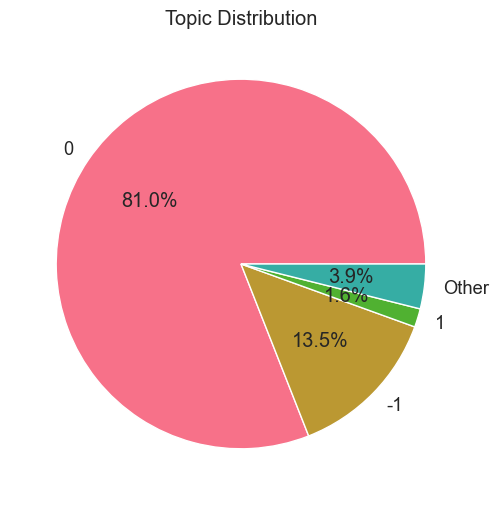

In [379]:
# topic_info = topic_model.get_topic_info()

# for topic in topic_info.itertuples():
#     if topic.Topic != -1 and topic.Topic < 5:
#         print(f"\nTopic {topic.Topic}: {topic.Count} documents")
#         top_words = topic_model.get_topic(topic.Topic)
#         print("Top words and their scores:")
#         for word, score in top_words[:10]:
#             print(f"- {word}: {score:.3f}")

# topic_counts = results_df['topic'].value_counts()
# topic_pct = topic_counts / len(results_df) * 100

# mask = topic_pct >= 1.5
# large_topics = topic_pct[mask]
# other = pd.Series({'Other': topic_pct[~mask].sum()})
# final_counts = pd.concat([large_topics, other])

# plt.figure(figsize=(10, 6))
# plt.pie(final_counts, labels=final_counts.index, autopct='%1.1f%%')
# plt.title('Topic Distribution')
# plt.show()

It wasn't clear enough for me what each topic was about, so I decided to use `gpt-4o-mini` to label each topic based on the top words.

In [131]:
# from openai import OpenAI
# from dotenv import load_dotenv

# load_dotenv()
# client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# def get_topic_label(topic_words, client):
#     word_list = "\n".join([f"- {word}: {score:.3f}" for word, score in topic_words[:10]])

#     try:
#         response = client.chat.completions.create(
#             model="gpt-4o-mini",
#             messages=[
#                 {
#                     "role": "system",
#                     "content": "You are a topic labeling assistant. Provide a single specific word to categorize ChatGPT conversations. Never use 'outlier' or 'misc'."
#                 },
#                 {
#                     "role": "user",
#                     "content": f"""These are topic-related words from ChatGPT conversations:

# {word_list}

# Examples:
# - For words like "code, python, function": respond with "programming"
# - For words like "essay, write, thesis": respond with "writing"
# - For words like "math, equation, solve": respond with "mathematics"

# Provide ONE specific word that best describes this topic. Just the word, no explanation."""
#                 }
#             ],
#             temperature=0.2,
#         )
#         return response.choices[0].message.content.strip().lower()
#     except Exception as e:
#         print(f"Error getting label: {e}")
#         return "error"

# def label_topics(topic_model):
#     topic_info = topic_model.get_topic_info()

#     print("\nLabeling Topics:")
#     print("-" * 50)
#     print(f"{'Topic':^6} | {'Label':^15} | {'Documents':^10}")
#     print("-" * 50)

#     for _, row in topic_info.iterrows():
#         if row.Topic != -1:
#             words = topic_model.get_topic(row.Topic)
#             label = get_topic_label(words, client)
#             topic_info.loc[topic_info['Topic'] == row.Topic, 'label'] = label
#             print(f"{row.Topic:^6} | {label:^15} | {row.Count:^10}")

#     print("-" * 50)

#     topic_info.to_csv('data/topic_labels.csv', index=False)
#     return topic_info

# topic_info_labeled = label_topics(topic_model)



Labeling Topics:
--------------------------------------------------
Topic  |      Label      | Documents 
--------------------------------------------------
  0    |    analysis     |   48151   
  1    |    language     |    964    
  2    |      audio      |    474    
  3    |     quantum     |    290    
  4    |    birthday     |    224    
  5    | webdevelopment  |    142    
  6    |     fantasy     |    137    
  7    |    beverage     |    106    
  8    |   scheduling    |     95    
  9    |    identity     |     94    
  10   |  optimization   |     80    
  11   |   earthquake    |     74    
  12   |    streaming    |     69    
  13   |   ornithology   |     69    
  14   |      drama      |     69    
  15   |  documentation  |     66    
  16   |     sports      |     51    
  17   |   automation    |     49    
  18   |     django      |     38    
  19   |     physics     |     32    
  20   |   programming   |     25    
  21   |   agriculture   |     24    
  22  

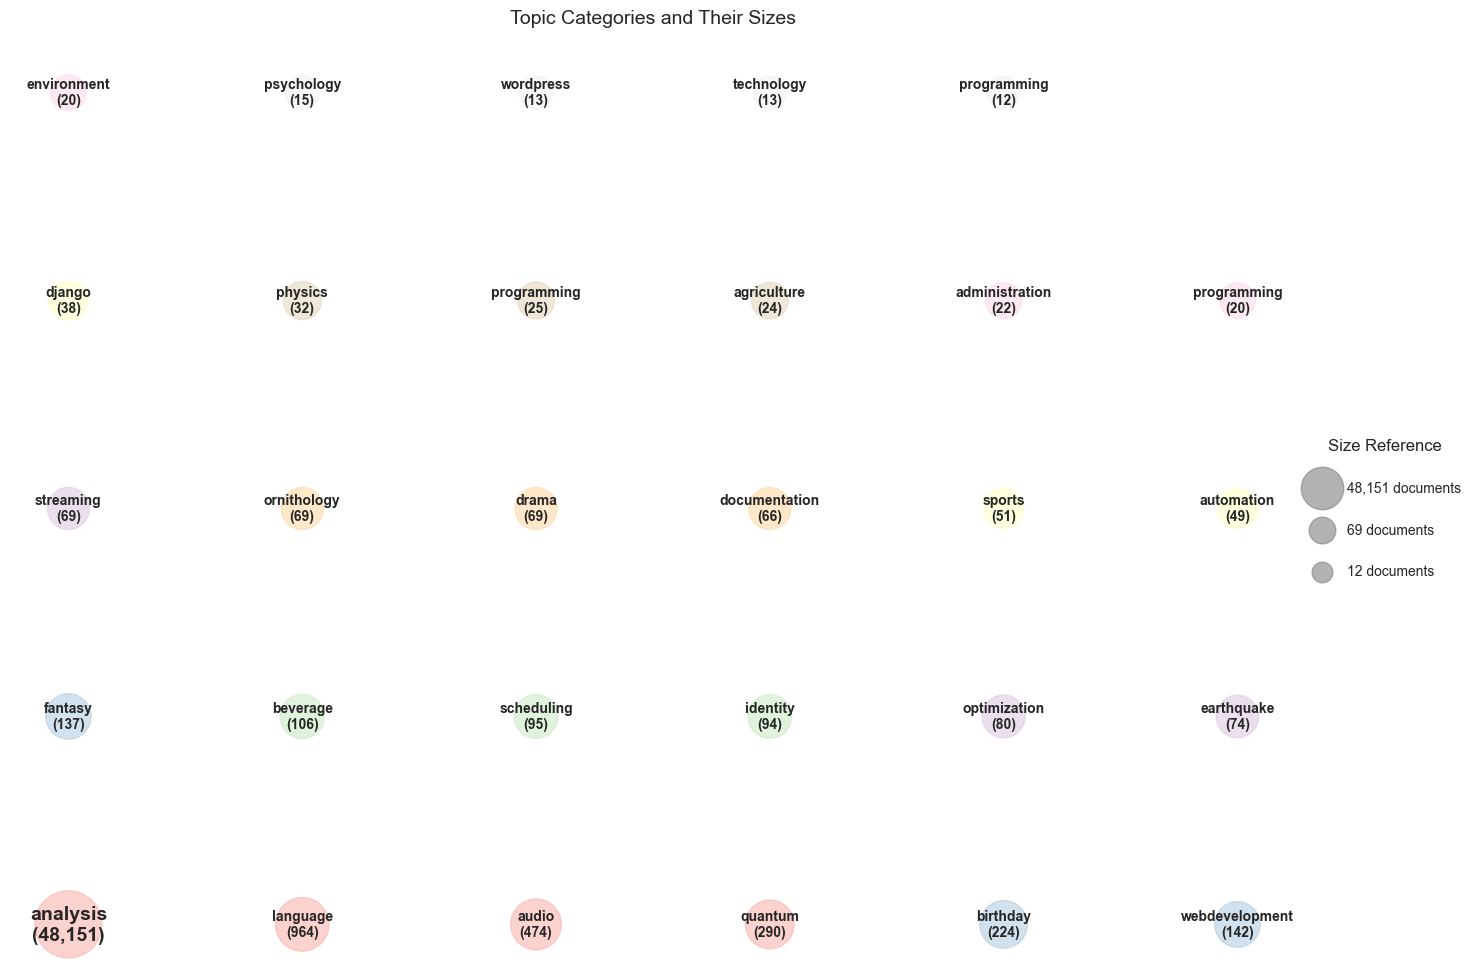

In [140]:
# def plot_topic_bubbles(topic_info_labeled):
#     topics = topic_info_labeled[topic_info_labeled['Topic'] != -1]
#     labels = topics['label'].values
#     sizes = topics['Count'].values

#     bubble_sizes = np.log10(sizes + 1) * 500

#     num_topics = len(labels)
#     cols = int(np.ceil(np.sqrt(num_topics)))
#     rows = int(np.ceil(num_topics / cols))

#     x = np.arange(cols) * 2
#     y = np.arange(rows) * 1.5
#     x, y = np.meshgrid(x, y)
#     x = x.flatten()[:num_topics]
#     y = y.flatten()[:num_topics]

#     plt.figure(figsize=(15, 10))

#     colors = plt.cm.Pastel1(np.linspace(0, 1, num_topics))
#     plt.scatter(x, y, s=bubble_sizes, alpha=0.6, c=colors)

#     for i, (label, size) in enumerate(zip(labels, sizes)):
#         font_size = min(max(10, np.log10(size + 1) * 3), 14)

#         plt.annotate(
#             f'{label}\n({size:,})',
#             (x[i], y[i]),
#             ha='center',
#             va='center',
#             fontsize=font_size,
#             fontweight='bold'
#         )

#     plt.title('Topic Categories and Their Sizes', pad=20, fontsize=14)
#     plt.axis('off')

#     legend_sizes = [min(sizes), np.median(sizes), max(sizes)]
#     legend_elements = [
#         plt.scatter(
#             [], [],
#             s=np.log10(size + 1) * 200,
#             c='gray',
#             alpha=0.6,
#             label=f'{int(size):,} documents'
#         )
#         for size in sorted(legend_sizes, reverse=True)
#     ]
#     plt.legend(
#         handles=legend_elements,
#         title='Size Reference',
#         title_fontsize=12,
#         fontsize=10,
#         loc='center left',
#         bbox_to_anchor=(1, 0.5),
#         scatterpoints=1,
#         labelspacing=2
#     )

#     plt.tight_layout()
#     plt.show()

# plot_topic_bubbles(topic_info_labeled)

So then I've decided to take other, simpler approach:
- TF-IDF instead of BERTopic
- MiniBatchKMeans instead of HDBSCAN
- TruncatedSVD instead of UMAP

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from tqdm import tqdm


def setup_nltk():
    nltk.download("punkt", quiet=True)
    nltk.download("stopwords", quiet=True)
    nltk.download("wordnet", quiet=True)

    stop_words = set(stopwords.words("english"))
    stop_words.update(
        {
            # Basic conversation
            "help",
            "please",
            "thanks",
            "hello",
            "hi",
            "chatgpt",
            "gpt",
            "ai",
            "could",
            "would",
            "tell",
            "explain",
            "need",
            "want",
            "like",
            # Common words that create noise
            "one",
            "way",
            "use",
            "also",
            "however",
            "tell",
            "would",
            "could",
            "should",
            "example",
            "information",
            "different",
            "new",
            "try",
            "provide",
            "following",
            "work",
            "list",
            "time",
            "first",
            "question",
            "answer",
            "write",
            "know",
            "help",
            "want",
            "like",
            "good",
            # Command words
            "can",
            "will",
            "should",
            "make",
            "create",
            "generate",
            "give",
            "show",
            "explain",
            "describe",
            "provide",
            "tell",
            "write",
            # Common ChatGPT-specific words
            "prompt",
            "response",
            "message",
            "chat",
            "asking",
            "question",
            "answer",
            "request",
            "task",
            "output",
            "result",
        }
    )

    return stop_words, WordNetLemmatizer()


def preprocess_text(text, stop_words, lemmatizer):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r"[^a-z\s?.!,]", "", text)
    text = re.sub(r"\s+", " ", text)

    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words and len(word) > 1
    ]

    return " ".join(tokens)


def get_initial_messages(df, min_text_length=20, sample_size=-1):
    initial_messages = df[
        (df["message_order"] == 0)
        & (df["user"] == "Anonymous")
        & (df["language"] == "en")
        & (df["message"].str.len() >= min_text_length)
    ].copy()

    if sample_size != -1:
        initial_messages = initial_messages.sample(
            n=min(sample_size, len(initial_messages)), random_state=42
        )

    return initial_messages


def process_texts(messages, stop_words, lemmatizer):
    processed_texts = [
        preprocess_text(text, stop_words, lemmatizer)
        for text in tqdm(messages["message"])
    ]

    valid_indices = [
        i for i, text in enumerate(processed_texts) if len(text.strip()) > 0
    ]

    return [processed_texts[i] for i in valid_indices], valid_indices


def vectorize_and_reduce(texts, n_components=100):
    vectorizer = TfidfVectorizer(
        max_features=15000, ngram_range=(1, 3), min_df=3, max_df=0.90, sublinear_tf=True
    )
    tfidf_matrix = vectorizer.fit_transform(texts)

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_matrix = svd.fit_transform(tfidf_matrix)

    norms = np.linalg.norm(reduced_matrix, axis=1)
    norms[norms == 0] = 1
    reduced_matrix = reduced_matrix / norms[:, np.newaxis]
    reduced_matrix = np.nan_to_num(reduced_matrix)

    return tfidf_matrix, reduced_matrix, vectorizer


def get_topic_keywords(tfidf_matrix, cluster_labels, vectorizer, n_topics):
    topic_keywords = {}

    for topic_id in range(n_topics):
        cluster_docs = tfidf_matrix[cluster_labels == topic_id]
        if cluster_docs.shape[0] > 0:
            avg_tfidf = cluster_docs.mean(axis=0).A1
            top_indices = avg_tfidf.argsort()[-10:][::-1]
            keywords = [vectorizer.get_feature_names_out()[i] for i in top_indices]
            topic_keywords[topic_id] = ", ".join(keywords)

    return topic_keywords


def create_results_dataframe(
    initial_messages, cluster_labels, topic_keywords, processed_texts, valid_indices
):
    initial_messages = initial_messages.iloc[valid_indices].reset_index(drop=True)

    results_df = pd.DataFrame(
        {
            "post_number": initial_messages["post_number"].values,
            "topic": cluster_labels,
            "topic_keywords": [topic_keywords[t] for t in cluster_labels],
            "topic_size": pd.Series(cluster_labels).map(
                pd.Series(cluster_labels).value_counts()
            ),
            "processed_text": processed_texts,
            "original_message": initial_messages["message"].values,
        }
    )

    return results_df.sort_values(["topic_size", "topic"], ascending=[False, True])


def analyze_topics(
    df_expanded, output_dir="data", n_topics=30, sample_size=-1, min_text_length=30
):
    os.makedirs(output_dir, exist_ok=True)
    if Path(output_dir, "topic_analysis_results.csv").exists():
        print(f"Loading cached results from {output_dir}")
        return pd.read_csv(Path(output_dir, "topic_analysis_results.csv"))

    stop_words, lemmatizer = setup_nltk()
    initial_messages = get_initial_messages(df_expanded, min_text_length, sample_size)

    processed_texts, valid_indices = process_texts(
        initial_messages, stop_words, lemmatizer
    )

    try:
        tfidf_matrix, reduced_matrix, vectorizer = vectorize_and_reduce(processed_texts)

        kmeans = MiniBatchKMeans(
            n_clusters=n_topics,
            random_state=42,
            batch_size=2000,
            max_iter=300,
            init="k-means++",
            n_init=10,
        )
        cluster_labels = kmeans.fit_predict(reduced_matrix)

        topic_keywords = get_topic_keywords(
            tfidf_matrix, cluster_labels, vectorizer, n_topics
        )
        results_df = create_results_dataframe(
            initial_messages,
            cluster_labels,
            topic_keywords,
            processed_texts,
            valid_indices,
        )

        results_df.to_csv(
            os.path.join(output_dir, "topic_analysis_results.csv"), index=False
        )

        return results_df
    except Exception as e:
        print(f"Error during processing: {str(e)}")
        raise


fast_topic_df = analyze_topics(df_expanded, n_topics=30, min_text_length=30)

In [241]:
print("\nTopic Distribution:")
summary = (
    fast_topic_df.groupby("topic")
    .agg({"post_number": "count", "topic_keywords": "first"})
    .sort_values("post_number", ascending=False)
)
print(summary)


Topic Distribution:
       post_number                                     topic_keywords
topic                                                                
10           17966  using, code, english, language, data, file, ap...
4             3401  research, human, student, technology, experien...
26            3292  day, many, people, life, plan, friend, food, m...
16            3196  used, state, number, process, set, order, data...
7             3034  im, say, thing, dont, think, get, something, g...
21            2866  return, function, string, import, const, value...
1             2497  project, software, product, manager, job, deve...
12            1747  company, business, marketing, tech, plan, star...
15            1428  question, ask, ask question, interview, answer...
5             1344  table, column, sql, database, row, query, id, ...
13            1303  python, code, python code, using, code python,...
29            1102  result, search result, search, url, web search...

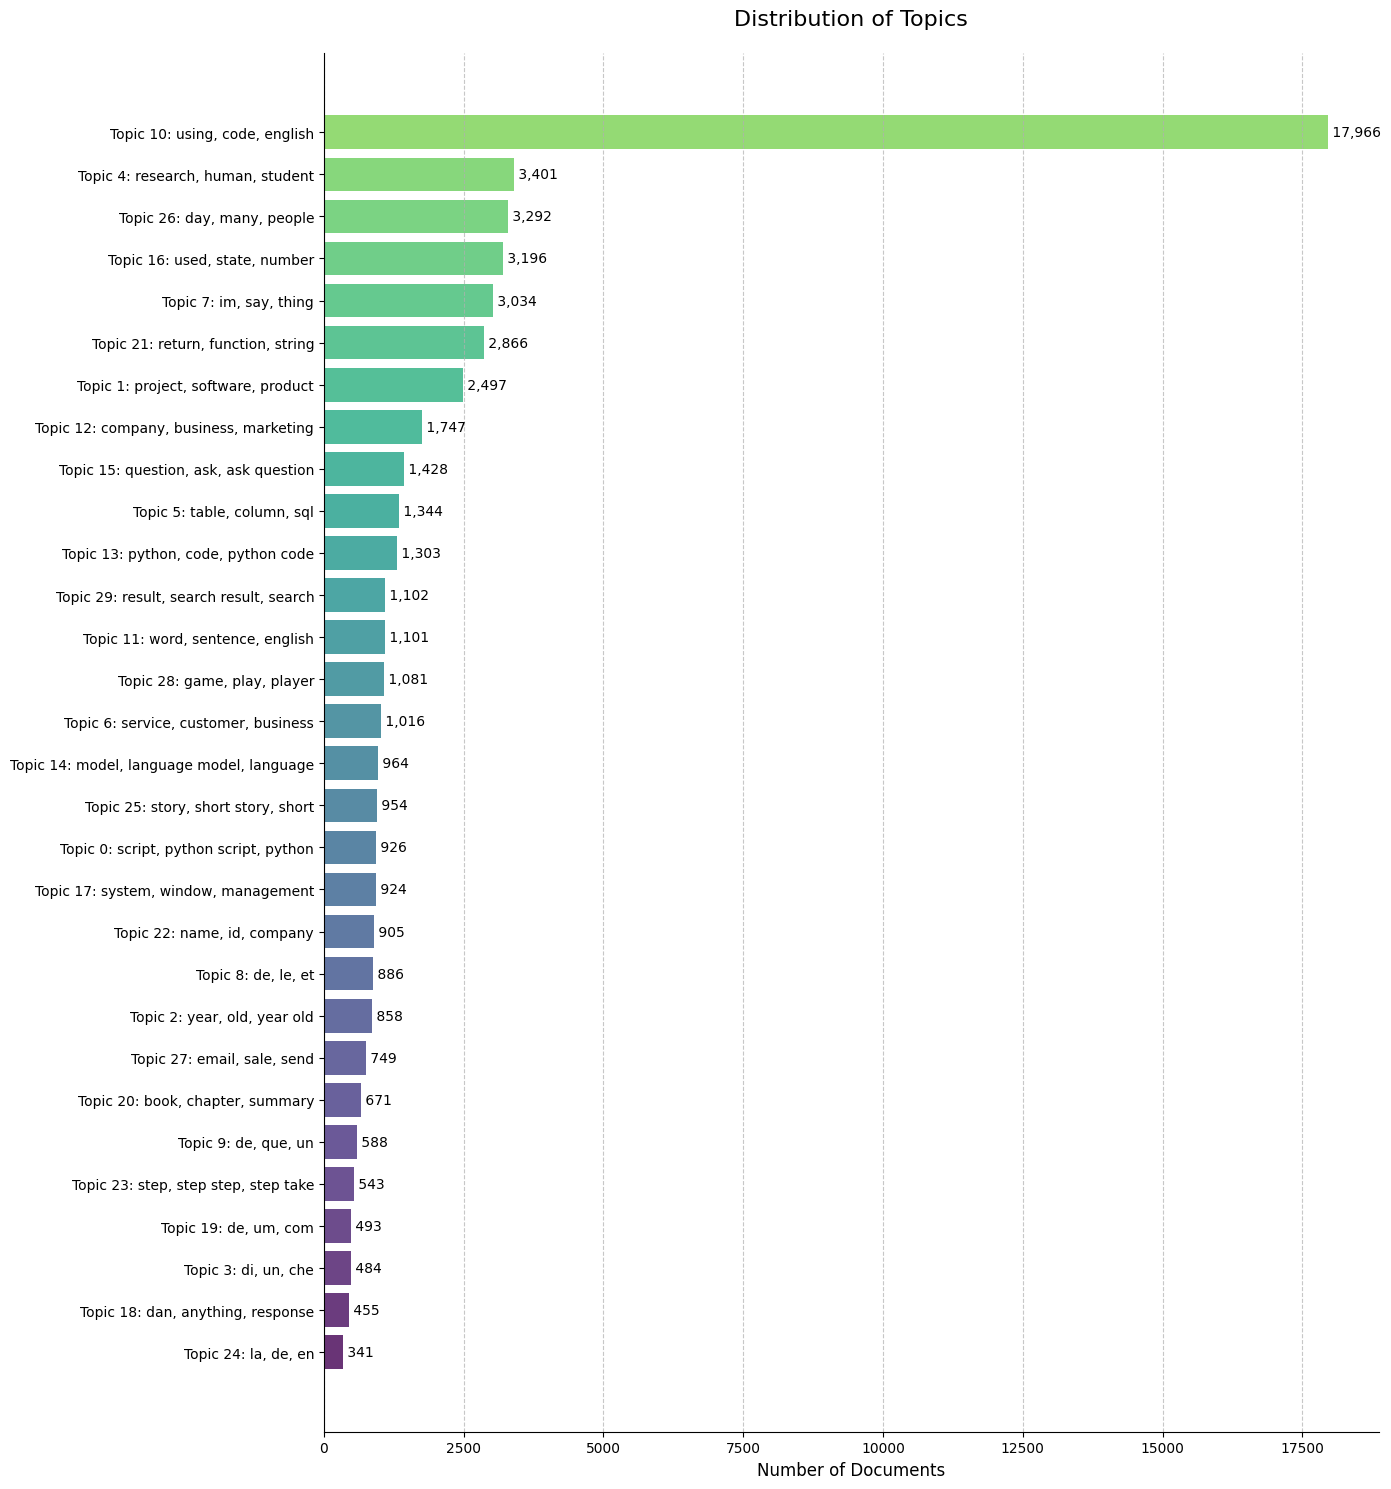

In [242]:
def plot_topic_distribution(results_df):
    topic_counts = results_df["topic"].value_counts()
    topic_sizes = topic_counts.sort_values(ascending=True)

    height_per_topic = 0.5
    fig_height = max(10, len(topic_sizes) * height_per_topic)

    fig, ax = plt.subplots(figsize=(14, fig_height))

    y_pos = np.arange(len(topic_sizes))
    bars = ax.barh(
        y_pos,
        topic_sizes.values,
        color=plt.cm.viridis(np.linspace(0, 0.8, len(topic_sizes))),
        alpha=0.8,
    )

    ax.set_xlabel("Number of Documents", fontsize=12)
    ax.set_title("Distribution of Topics", fontsize=16, pad=20)

    labels = []
    for topic_id in topic_sizes.index:
        keywords = results_df[results_df["topic"] == topic_id]["topic_keywords"].iloc[0]
        top_keywords = keywords.split(", ")[:3]
        labels.append(f'Topic {topic_id}: {", ".join(top_keywords)}')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=10)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    for bar in bars:
        width = bar.get_width()
        ax.text(
            width,
            bar.get_y() + bar.get_height() / 2,
            f" {int(width):,}",
            va="center",
            fontsize=10,
        )

    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_topic_distribution(fast_topic_df)

Now I have better topic division.

Next step is to label topics and merge using `gpt-4o`

In [243]:
from dotenv import load_dotenv
from openai import OpenAI
from pathlib import Path
import pandas as pd


def get_topic_label(keywords, existing_labels, client):
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "Create general topic labels or reuse existing ones if similar. Return exactly one label.",
                },
                {
                    "role": "user",
                    "content": f"""Keywords: {keywords}

Existing labels so far: {existing_labels if existing_labels else 'None yet'}

Examples:
Input: marketing, finance, strategy, sales
Output: business

Input: code, python, function, debug
Output: programming

If the keywords are similar to an existing label's topic, use that label.
Otherwise, create a new general label (1-2 words).
Return only the label, no explanation.""",
                },
            ],
            temperature=0.3,
        )
        return response.choices[0].message.content.strip().lower()
    except Exception as e:
        print(f"Error getting label: {e}")
        return "error"


def label_topics(results_df, output_path="data/fast_topic_labels.csv"):
    if Path(output_path).exists():
        print(f"Loading cached labels from {output_path}")
        return pd.read_csv(output_path)

    load_dotenv()
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    topic_info = (
        results_df.groupby("topic")
        .agg({"topic_keywords": "first", "topic_size": "first"})
        .reset_index()
    )

    topic_info = topic_info.sort_values("topic_size", ascending=False)

    labels = []
    existing_labels = []
    topic_mapping = {}

    for _, row in topic_info.iterrows():
        label = get_topic_label(row["topic_keywords"], existing_labels, client)
        labels.append(label)

        if label not in existing_labels:
            existing_labels.append(label)
            topic_mapping[label] = [row["topic"]]
        else:
            print(f"Merging topic {row['topic']} into existing label '{label}'")
            topic_mapping[label].append(row["topic"])

    topic_info["label"] = labels

    merged_topics = {}
    for label, topics in topic_mapping.items():
        if len(topics) > 1:
            main_topic = min(topics)
            for topic in topics:
                if topic != main_topic:
                    merged_topics[topic] = main_topic

                    main_size = topic_info.loc[
                        topic_info["topic"] == main_topic, "topic_size"
                    ].iloc[0]
                    merged_size = topic_info.loc[
                        topic_info["topic"] == topic, "topic_size"
                    ].iloc[0]
                    topic_info.loc[topic_info["topic"] == main_topic, "topic_size"] = (
                        main_size + merged_size
                    )
                    topic_info = topic_info[topic_info["topic"] != topic]

            print(
                f"\nMerged topics {topics} into topic {main_topic} with label '{label}'"
            )

    results_df["topic"] = results_df["topic"].map(lambda x: merged_topics.get(x, x))

    topic_info.to_csv(output_path, index=False)
    print(f"\nLabels saved to {output_path}")

    return topic_info


topic_info_labeled = label_topics(fast_topic_df)

Merging topic 21 into existing label 'programming'
Merging topic 1 into existing label 'programming'
Merging topic 15 into existing label 'communication'
Merging topic 5 into existing label 'data analysis'
Merging topic 13 into existing label 'programming'
Merging topic 11 into existing label 'communication'
Merging topic 28 into existing label 'technology'
Merging topic 6 into existing label 'business'
Merging topic 14 into existing label 'technology'
Merging topic 0 into existing label 'programming'
Merging topic 17 into existing label 'technology'
Merging topic 22 into existing label 'technology'
Merging topic 2 into existing label 'lifestyle'
Merging topic 27 into existing label 'business'
Merging topic 20 into existing label 'literature'
Merging topic 9 into existing label 'language'
Merging topic 23 into existing label 'education'
Merging topic 19 into existing label 'language'
Merging topic 3 into existing label 'language'
Merging topic 18 into existing label 'communication'
Mer

In [244]:
print("-" * 50)
print(f"{'Topic':^6} | {'Label':^28} | {'Size':^10}")
print("-" * 50)
for _, row in topic_info_labeled.iterrows():
    print(f"{row['topic']:^6} | {row['label']:^28} | {row['topic_size']:^10}")

--------------------------------------------------
Topic  |            Label             |    Size   
--------------------------------------------------
  4    |          education           |    3944   
  7    |        communication         |    6018   
  5    |        data analysis         |    4540   
  6    |           business           |    3512   
  14   |          technology          |    4976   
  0    |         programming          |   25558   
  2    |          lifestyle           |    4150   
  20   |          literature          |    1625   
  3    |           language           |    2792   


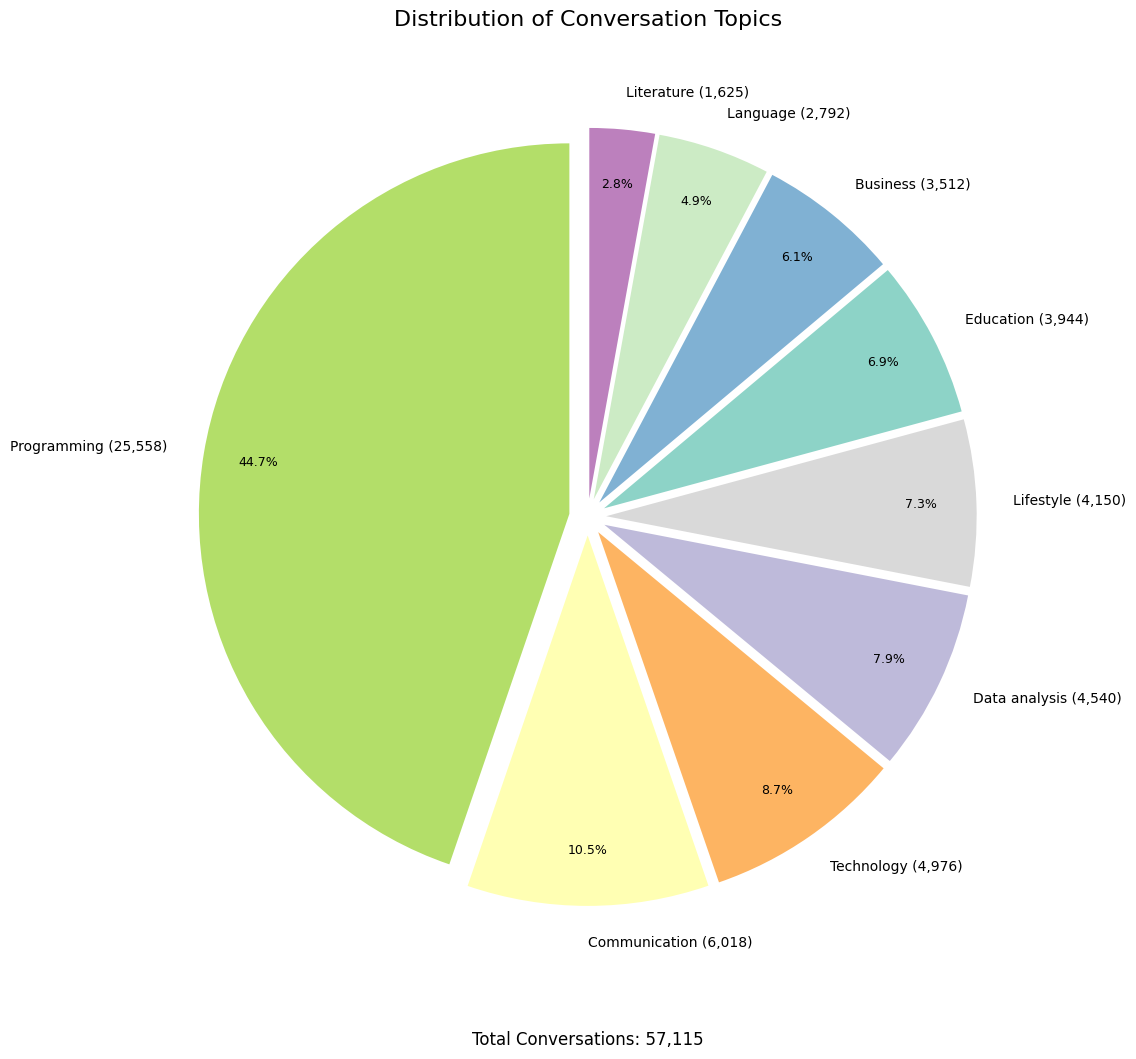

In [245]:
def create_color_mapping(merged_topic_info):
    distinct_colors = []
    n_colors = len(merged_topic_info) + 1

    color_maps = [plt.cm.Set3, plt.cm.Paired, plt.cm.tab20, plt.cm.Set1]
    current_map_idx = 0
    colors_needed = n_colors

    while colors_needed > 0:
        current_map = color_maps[current_map_idx]
        n_colors_in_map = min(colors_needed, current_map.N)
        distinct_colors.extend(current_map(np.linspace(0, 1, n_colors_in_map)))
        colors_needed -= n_colors_in_map
        current_map_idx = (current_map_idx + 1) % len(color_maps)

    color_mapping = dict(
        zip(merged_topic_info["label"], distinct_colors[: len(merged_topic_info)])
    )
    color_mapping["Other"] = distinct_colors[len(merged_topic_info)]

    return color_mapping


def plot_topic_pie(merged_topic_info, min_percentage=2, color_mapping=None):
    total_docs = merged_topic_info["topic_size"].sum()
    merged_topic_info["percentage"] = merged_topic_info["topic_size"] / total_docs * 100

    main_topics = merged_topic_info[merged_topic_info["percentage"] >= min_percentage]
    small_topics = merged_topic_info[merged_topic_info["percentage"] < min_percentage]

    if not small_topics.empty:
        other_size = small_topics["topic_size"].sum()
        other_percentage = small_topics["percentage"].sum()
        plot_data = pd.concat(
            [
                main_topics,
                pd.DataFrame(
                    {
                        "label": ["Other"],
                        "topic_size": [other_size],
                        "percentage": [other_percentage],
                        "topic": [-1],
                    }
                ),
            ]
        )
    else:
        plot_data = main_topics

    plot_data = plot_data.sort_values("topic_size", ascending=False)

    colors = [color_mapping[label] for label in plot_data["label"]]

    plt.figure(figsize=(15, 10))
    wedges, texts, autotexts = plt.pie(
        plot_data["topic_size"],
        labels=[
            f"{label.capitalize()} ({size:,})"
            for label, size in zip(plot_data["label"], plot_data["topic_size"])
        ],
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
        pctdistance=0.85,
        explode=[0.05] * len(plot_data),
    )

    plt.setp(autotexts, size=9)
    plt.setp(texts, size=10)
    plt.title("Distribution of Conversation Topics", fontsize=16, pad=20)
    plt.figtext(
        0.5, -0.05, f"Total Conversations: {total_docs:,}", ha="center", fontsize=12
    )
    plt.tight_layout()
    plt.show()


color_mapping = create_color_mapping(topic_info_labeled)
plot_topic_pie(topic_info_labeled, min_percentage=1, color_mapping=color_mapping)

In [246]:
def get_avg_message_length(post_number, df_expanded):
    conversation = df_expanded[df_expanded["post_number"] == post_number]
    return np.mean([len(str(msg)) for msg in conversation["message"]])


topic_avg_lengths = (
    fast_topic_df.groupby("topic")
    .agg(
        {
            "post_number": lambda x: np.mean(
                [get_avg_message_length(pn, df_expanded) for pn in x]
            )
        }
    )
    .reset_index()
)
topic_avg_lengths = topic_avg_lengths.merge(
    topic_info_labeled[["topic", "label"]], on="topic", how="left"
)
topic_avg_lengths = topic_avg_lengths.sort_values("post_number", ascending=True)

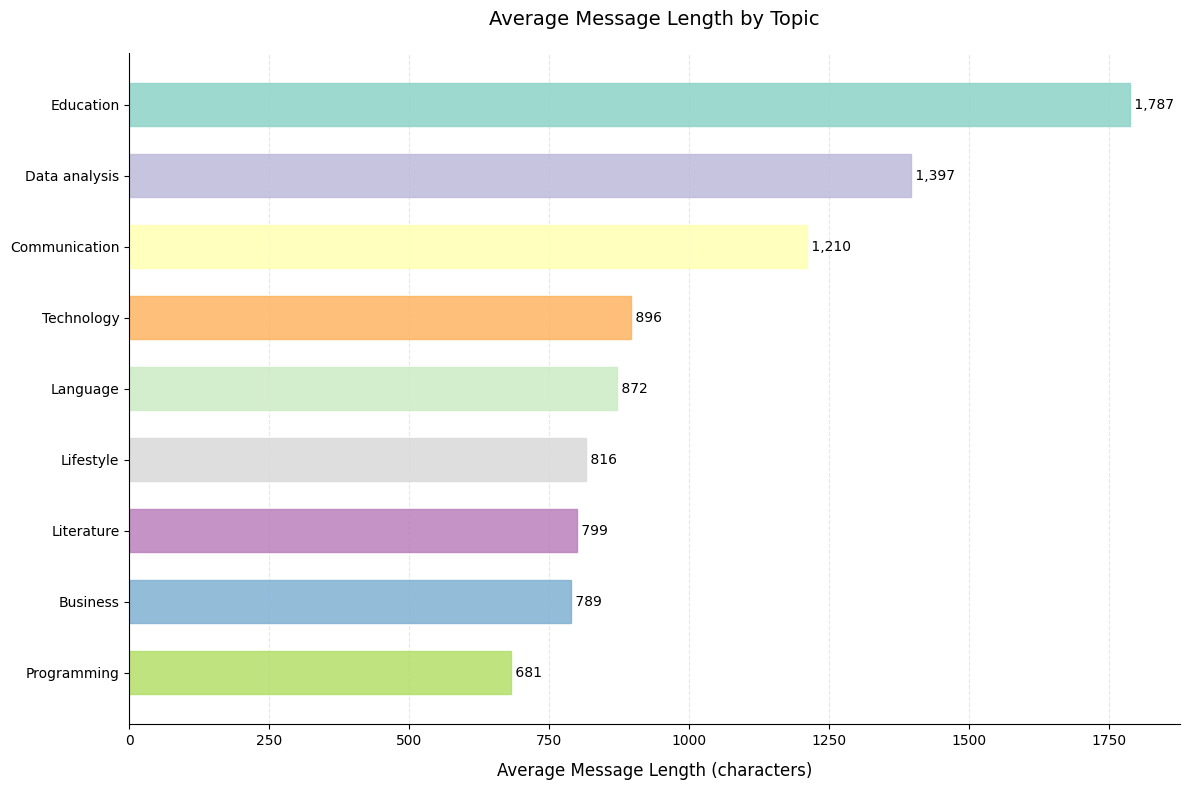

In [247]:
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(
    range(len(topic_avg_lengths)),
    topic_avg_lengths["post_number"],
    height=0.6,
    alpha=0.85,
)

for i, bar in enumerate(bars):
    bar.set_color(color_mapping[topic_avg_lengths["label"].iloc[i]])
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f" {int(width):,}",
        va="center",
        fontsize=10,
    )

ax.set_xlabel("Average Message Length (characters)", fontsize=12, labelpad=10)

ax.set_title("Average Message Length by Topic", fontsize=14, pad=20)

labels = [f"{label.capitalize()}" for label in topic_avg_lengths["label"]]
ax.set_yticks(range(len(topic_avg_lengths)))
ax.set_yticklabels(labels, fontsize=10)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.grid(axis="x", linestyle="--", alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

In [248]:
def get_avg_lengths_by_role(post_number, df_expanded):
    conversation = df_expanded[df_expanded["post_number"] == post_number]

    gpt_msgs = conversation[conversation["user"] == "Chat GPT"]["message"]
    user_msgs = conversation[conversation["user"] == "Anonymous"]["message"]

    gpt_avg = np.mean([len(str(msg)) for msg in gpt_msgs]) if len(gpt_msgs) > 0 else 0
    user_avg = (
        np.mean([len(str(msg)) for msg in user_msgs]) if len(user_msgs) > 0 else 0
    )

    return gpt_avg, user_avg


gpt_user_avg_topic_length_df = (
    fast_topic_df.groupby("topic")
    .agg(
        {
            "post_number": lambda x: [
                get_avg_lengths_by_role(pn, df_expanded) for pn in x
            ]
        }
    )
    .reset_index()
)

gpt_user_avg_topic_length_df["gpt_avg"] = gpt_user_avg_topic_length_df[
    "post_number"
].apply(lambda x: np.mean([t[0] for t in x]))
gpt_user_avg_topic_length_df["user_avg"] = gpt_user_avg_topic_length_df[
    "post_number"
].apply(lambda x: np.mean([t[1] for t in x]))
gpt_user_avg_topic_length_df = gpt_user_avg_topic_length_df.drop("post_number", axis=1)

message_length_by_topic_df = gpt_user_avg_topic_length_df.merge(
    topic_info_labeled[["topic", "label"]], on="topic", how="left"
)

message_length_by_topic_df["ratio"] = (
    message_length_by_topic_df["gpt_avg"] / message_length_by_topic_df["user_avg"]
)
message_length_by_topic_df = message_length_by_topic_df.sort_values(
    "ratio", ascending=True
)

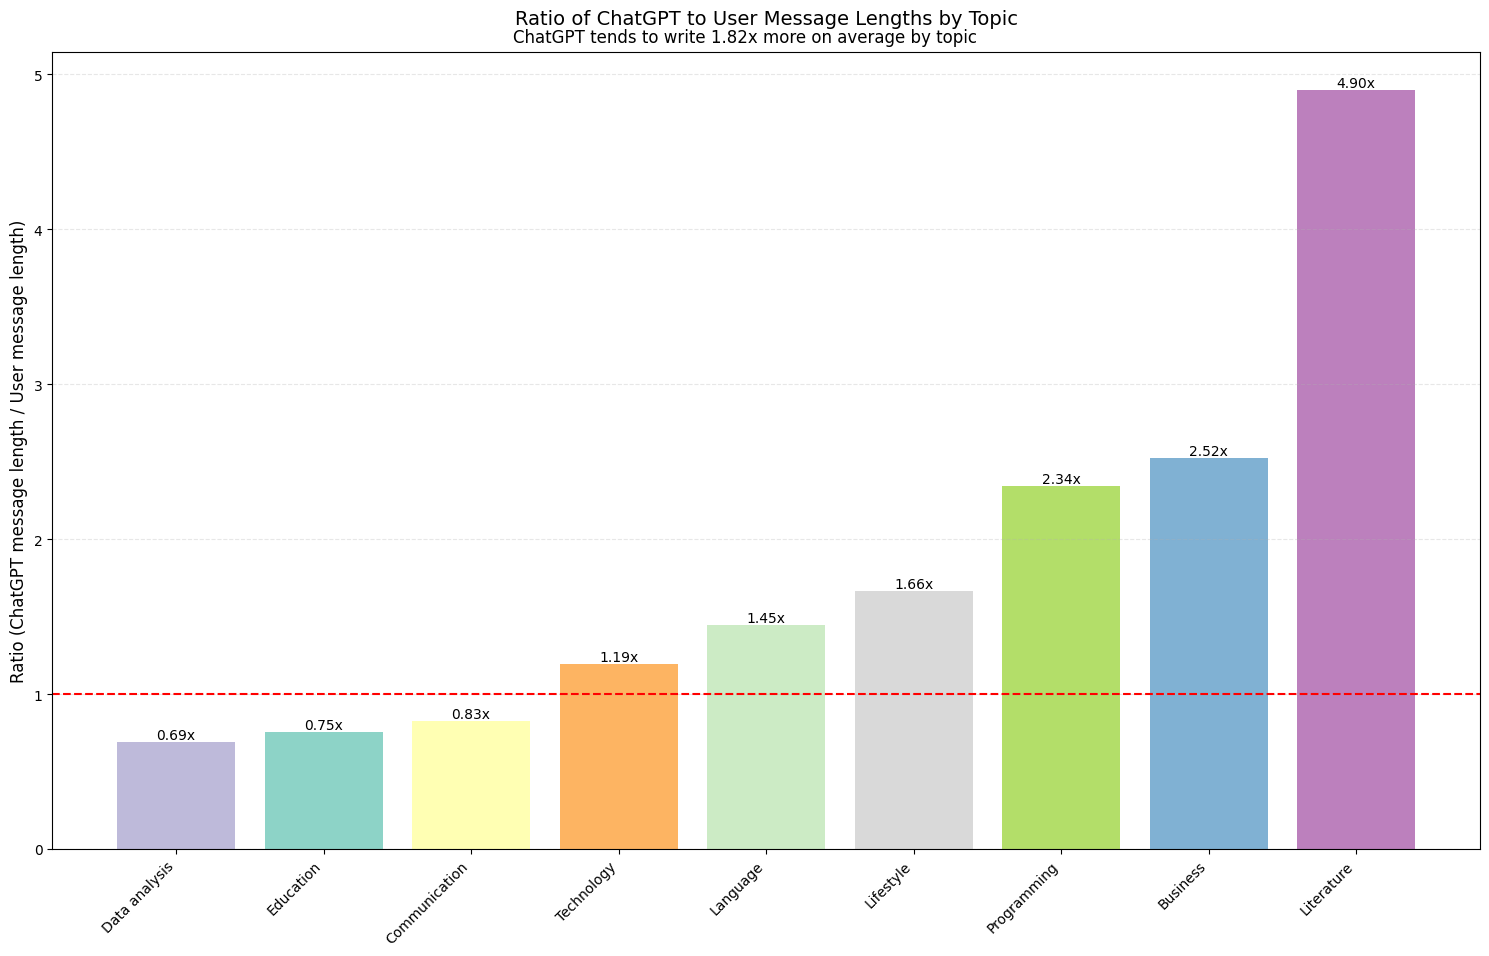

In [251]:
overall_ratio = message_length_by_topic_df["ratio"].mean()

plt.figure(figsize=(15, 10))

bars = plt.bar(
    range(len(message_length_by_topic_df)),
    message_length_by_topic_df["ratio"],
    color=[color_mapping[label] for label in message_length_by_topic_df["label"]],
)

plt.ylabel("Ratio (ChatGPT message length / User message length)", fontsize=12)
plt.title("Ratio of ChatGPT to User Message Lengths by Topic", fontsize=14, pad=20)
plt.suptitle(
    f"ChatGPT tends to write {overall_ratio:.2f}x more on average by topic",
    fontsize=12,
    y=0.9325,
)

plt.axhline(y=1, color="r", linestyle="--")

labels = [f"{label.capitalize()}" for label in message_length_by_topic_df["label"]]
plt.xticks(range(len(message_length_by_topic_df)), labels, rotation=45, ha="right")

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}x",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

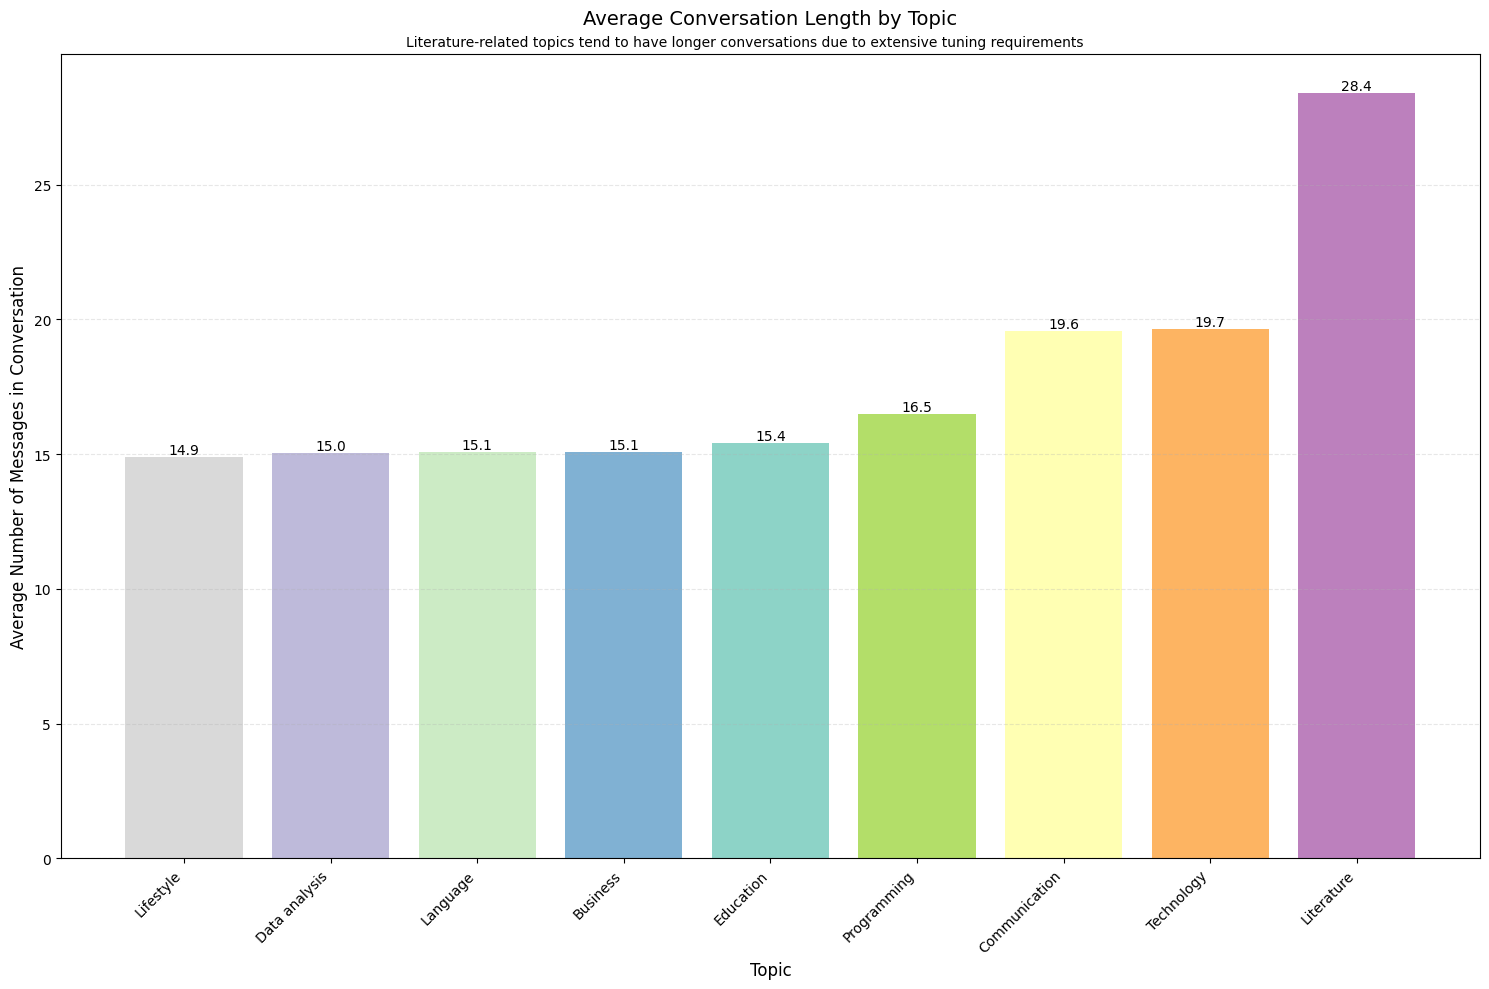

In [253]:
conversation_lengths = df_expanded.groupby("post_number").size().to_dict()
topic_sizes = fast_topic_df["topic"].value_counts().to_dict()
topic_stats = {}
for topic in fast_topic_df["topic"].unique():
    topic_posts = fast_topic_df[fast_topic_df["topic"] == topic]["post_number"]
    lengths = [conversation_lengths.get(post, 0) for post in topic_posts]
    topic_stats[topic] = {"mean_length": np.mean(lengths), "count": topic_sizes[topic]}

plot_data = pd.DataFrame.from_dict(topic_stats, orient="index")
plot_data = plot_data.reset_index().rename(columns={"index": "topic"})
plot_data = plot_data.merge(
    topic_info_labeled[["topic", "label"]], on="topic", how="left"
)
plot_data = plot_data.sort_values("mean_length", ascending=True)

plt.figure(figsize=(15, 10))

bars = plt.bar(
    range(len(plot_data)),
    plot_data["mean_length"],
    color=[color_mapping[label] for label in plot_data["label"]],
)

plt.title("Average Conversation Length by Topic\n", fontsize=14)
plt.figtext(
    0.5,
    0.948,
    "Literature-related topics tend to have longer conversations due to extensive tuning requirements",
    fontsize=10,
    ha="center",
)
plt.ylabel("Average Number of Messages in Conversation", fontsize=12)
plt.xlabel("Topic", fontsize=12)

labels = [f"{label.capitalize()}" for label in plot_data["label"]]

plt.xticks(range(len(plot_data)), labels, rotation=45, ha="right")

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

### User Feedback on ChatGPT Responses

Checking how accurate ChatGPT was back then by analyzing how many users asked for corrections (dataset from analyzing dates of its gathering contains GPT-3.5, GPT-3.5-Turbo, and a bit of GPT-4).

I'm using again `gpt-4o-mini` to analyze this by giving to it previous chat gpt message, next user message, and asking it to classify whether the user asked for a correction or if they were just continuing the conversation.

_Note: 1% of the messages were feeded to the `gpt-4o-mini` model for analysis._


In [308]:
from pydantic import BaseModel, Field
import json
from typing import Dict, Literal


class CorrectionAnalysis(BaseModel):
    results: Dict[str, Literal["fix", "continue", "unclear"]] = Field(
        description="Dictionary mapping message indices to correction request types"
    )

    model_config = {
        "json_schema_extra": {
            "examples": [{"results": {"0": "fix", "1": "continue", "2": "unclear"}}]
        }
    }


CORRECTION_PROMPT = """You are analyzing whether users are asking ChatGPT to fix/correct its previous response. Evaluate each pair of messages and return your analysis in JSON format.

Rules for analysis:
1. Assess if the user is asking for a correction, clarification, or pointing out errors
2. Look for indicators like "that's wrong", "can you fix", "not what I meant", etc.
3. If unclear or the user is just continuing the conversation, mark accordingly

Categories:
- "fix" = User is asking for corrections or pointing out errors
- "continue" = User is continuing the conversation without requesting fixes
- "unclear" = Cannot determine the intent clearly

Input format:
[0] ChatGPT: <previous response>
    User: <next message>
[1] ChatGPT: <previous response>
    User: <next message>
...and so on

Required output format:
{
    "results": {
        "0": "fix|continue|unclear",
        "1": "fix|continue|unclear",
        ...
    }
}

Example input:
[0] ChatGPT: Here's how to solve x + 2 = 5...
    User: That's not correct, x should be 3 not 7

[1] ChatGPT: Python is a programming language...
    User: Great, can you show me some examples?

Example output:
{
    "results": {
        "0": "fix",
        "1": "continue"
    }
}"""


def analyze_correction_requests(
    df_expanded,
    output_path="data/correction_analysis.csv",
    batch_size=50,
    max_workers=4,
    sample_size=-1,
) -> pd.DataFrame:
    if Path(output_path).exists():
        print("Loading cached correction analysis results...")
        return pd.read_csv(output_path)

    df_temp = df_expanded.copy()
    df_temp["prev_user"] = df_temp.groupby("post_number")["user"].shift(1)
    df_temp["prev_message"] = df_temp.groupby("post_number")["message"].shift(1)

    message_pairs = df_temp[
        (df_temp["user"] == "Anonymous") & (df_temp["prev_user"] == "Chat GPT")
    ].copy()

    if sample_size != -1:
        message_pairs = message_pairs.sample(
            n=min(sample_size, len(message_pairs)), random_state=42
        ).sort_index()

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    def process_batch(pairs):
        try:
            formatted_pairs = "\n".join(
                f"[{i}] ChatGPT: {row.prev_message[:200]}\n    User: {row.message[:200]}"
                for i, row in enumerate(pairs.itertuples())
            )

            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": CORRECTION_PROMPT},
                    {"role": "user", "content": formatted_pairs},
                ],
                response_format={"type": "json_object"},
                temperature=0.1,
            )

            result = json.loads(response.choices[0].message.content)
            return list(CorrectionAnalysis(**result).results.values())
        except Exception as e:
            print(f"Error processing batch: {e}")
            return ["unclear"] * len(pairs)

    batch_indices = list(range(0, len(message_pairs), batch_size))
    message_batches = [
        (i, message_pairs.iloc[i : i + batch_size]) for i in batch_indices
    ]

    results = [None] * len(message_pairs)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_batch, batch): idx for idx, batch in message_batches
        }

        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Analyzing correction requests",
            ncols=100,
        ):
            idx = futures[future]
            batch_results = future.result()
            batch_length = len(batch_results)
            results[idx : idx + batch_length] = batch_results

    correction_df = pd.DataFrame(
        {
            "post_number": message_pairs["post_number"].values,
            "message_order": message_pairs["message_order"].values,
            "chatgpt_message": message_pairs["prev_message"].values,
            "user_message": message_pairs["message"].values,
            "correction_type": results,
        }
    )

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    correction_df.to_csv(output_path, index=False)

    return correction_df


correction_results = analyze_correction_requests(
    df_expanded,
    sample_size=10000,
    batch_size=20,
)

Analyzing correction requests: 100%|██████████████████████████████| 500/500 [06:47<00:00,  1.23it/s]


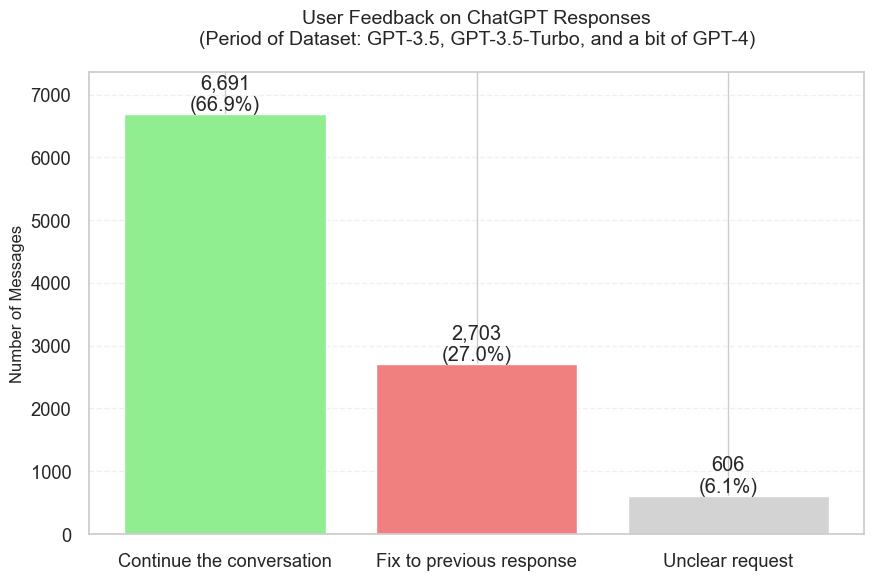

In [316]:
correction_counts = correction_results["correction_type"].value_counts()
labels = ["Continue the conversation", "Fix to previous response", "Unclear request"]

plt.figure(figsize=(10, 6))
bars = plt.bar(
    labels, correction_counts.values, color=["lightgreen", "lightcoral", "lightgray"]
)

plt.title(
    "User Feedback on ChatGPT Responses\n(Period of Dataset: GPT-3.5, GPT-3.5-Turbo, and a bit of GPT-4)",
    fontsize=14,
    pad=20,
)
plt.ylabel("Number of Messages", fontsize=12)

plt.ylim(0, correction_counts.max() * 1.1)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{int(height):,}\n({height/len(correction_results)*100:.1f}%)",
        ha="center",
        va="bottom",
    )

plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()

In [315]:
print("\nExamples of correction requests:")
correction_examples = correction_results[
    correction_results["correction_type"] == "fix"
].head()
for _, row in correction_examples.iterrows():
    print("\nChatGPT:", row["chatgpt_message"][:100], "...")
    print("User:", row["user_message"][:100], "...")


Examples of correction requests:

ChatGPT: Here is a complete C++ implementation for FizzBuzz: This program uses a for loop to iterate from 1 t ...
User: Great, now change the code so that the iteration length is provided by the user through stdin. ...

ChatGPT: Here is a modified version of the FizzBuzz program that checks for a valid iteration length and exit ...
User: Instead of checking for "*endptr != '\0'", wouldn't it be enough to just check for "endptr != &argv[ ...

ChatGPT: The name of the school that Harmony Hearts attend is not specified in the previous story. It would b ...
User: suggest a name of their school ...

ChatGPT: I apologize for the misunderstanding. Here is a revised syllabus that focuses more on the intellectu ...
User: I think Week 6 - 8 could be more rigorous, more esoteric, and more theoretical, while exploring expl ...

ChatGPT: It is not possible for me to combine all the best elements of each theory and form a new one, as it  ...
User: provide a theoret

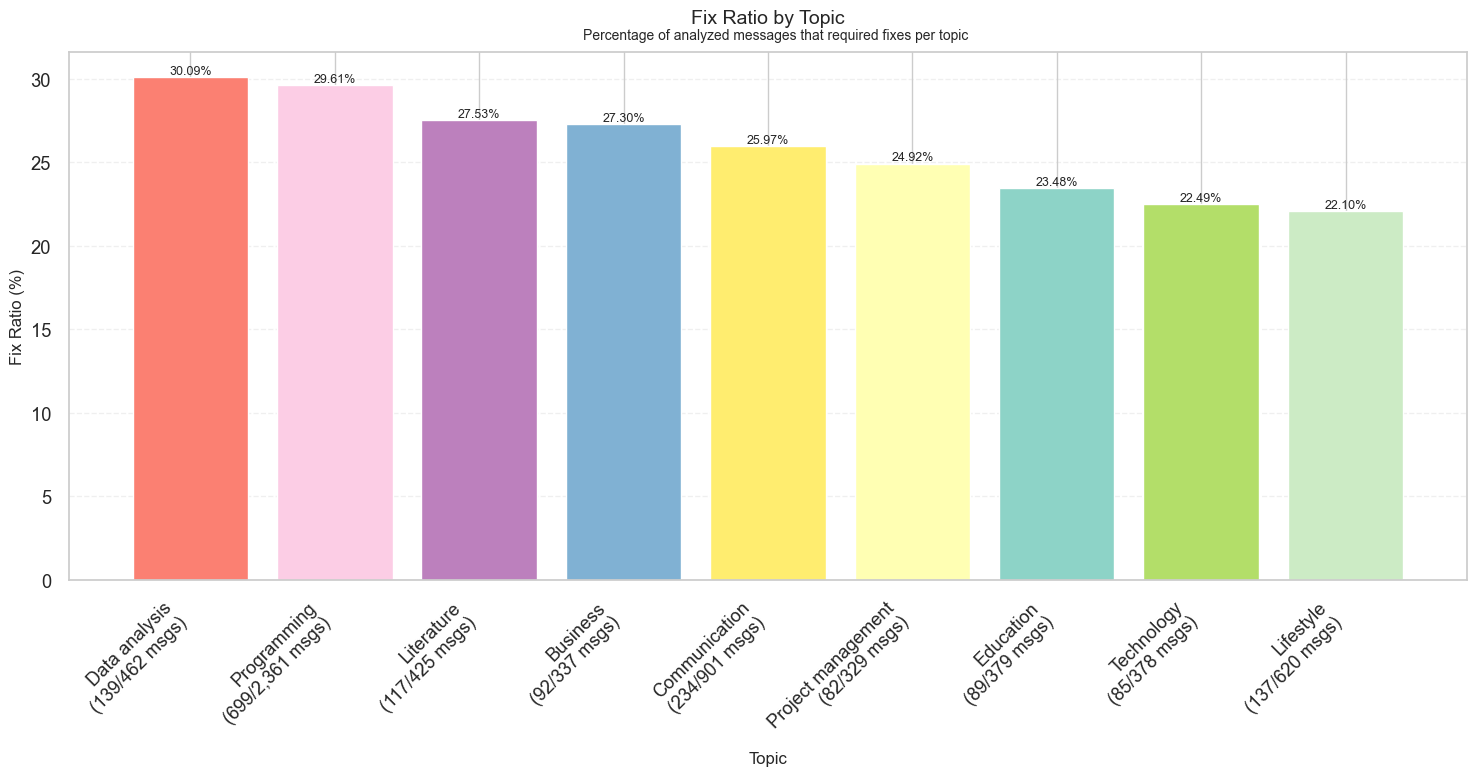

In [326]:
topic_fixes = {}
for topic in fast_topic_df["topic"].unique():
    topic_posts = set(fast_topic_df[fast_topic_df["topic"] == topic]["post_number"])
    topic_corrections = correction_results[
        correction_results["post_number"].isin(topic_posts)
    ]

    fixes = len(topic_corrections[topic_corrections["correction_type"] == "fix"])
    total_analyzed = len(topic_corrections)

    topic_fixes[topic] = {
        "fixes": fixes,
        "total_analyzed": total_analyzed,
        "fix_ratio": fixes / total_analyzed if total_analyzed > 0 else 0,
    }

fix_ratio_df = pd.DataFrame.from_dict(topic_fixes, orient="index").reset_index()
fix_ratio_df.columns = ["topic", "fixes", "total_analyzed", "fix_ratio"]
fix_ratio_df = fix_ratio_df.merge(
    topic_info_labeled[["topic", "label"]], on="topic", how="left"
)
fix_ratio_df = fix_ratio_df.sort_values("fix_ratio", ascending=False)

plt.figure(figsize=(15, 8))

bars = plt.bar(
    range(len(fix_ratio_df)),
    fix_ratio_df["fix_ratio"] * 100,
    color=[color_mapping[label] for label in fix_ratio_df["label"]],
)

plt.title("Fix Ratio by Topic\n", fontsize=14)
plt.figtext(
    0.525,
    0.935,
    "Percentage of analyzed messages that required fixes per topic",
    fontsize=10,
    ha="center",
)
plt.ylabel("Fix Ratio (%)", fontsize=12)
plt.xlabel("Topic", fontsize=12)

labels = [
    f"{label.capitalize()}\n({fixes:,}/{total:,} msgs)"
    for label, fixes, total in zip(
        fix_ratio_df["label"], fix_ratio_df["fixes"], fix_ratio_df["total_analyzed"]
    )
]

plt.xticks(range(len(fix_ratio_df)), labels, rotation=45, ha="right")

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2f}%",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### Prompt techniques users use

The analysis was performed using the `gpt-4o-mini` model.
The following prompt techniques were provided for classification:

- **Zero-shot**: Direct task without examples (e.g., "Translate 'Good morning' into Spanish.")
- **One-shot**: One example before the task (e.g., "Translate 'Hello' into Spanish: 'Hola'. Now, translate 'Good morning' into Spanish.")
- **Few-shot**: Multiple examples before the task (e.g., 
  "Translate the following into Spanish:
  - 'Hello': 'Hola'
  - 'Thank you': 'Gracias'
  - 'Good morning': 'Buenos días'")

- **Chain-of-thought**: Breaking down complex problems step by step (e.g., "Solve this problem step by step: If you have 5 apples and you buy 3 more, how many apples do you have in total?")
- **Role**: Assigning specific role/persona (e.g., "You are an experienced doctor. Explain the importance of a balanced diet.")
- **Instruction**: Clear, specific task instructions (e.g., "List three benefits of regular exercise in bullet points.")
- **Format**: Specifying output structure (e.g., "Provide a summary of the article in no more than 100 words.")
- **Contextual**: Including background information (e.g., "Considering the economic impacts of the 2008 financial crisis, discuss its effect on small businesses.")
- **Negative**: Specifying what to avoid (e.g., "Explain photosynthesis without using scientific jargon.")
- **Socratic**: Series of questions for deeper understanding (e.g., "What is renewable energy? Why is it important? How can it benefit the environment?")


In [94]:
import json
from pydantic import BaseModel, Field
from typing import List, Dict
from openai import RateLimitError
from time import sleep


class PromptAnalysis(BaseModel):
    results: Dict[str, List[str]] = Field(
        description="Dictionary mapping message indices to lists of prompt techniques"
    )

    model_config = {
        "json_schema_extra": {
            "examples": [
                {
                    "results": {
                        "0": ["zero-shot", "instruction"],
                        "1": ["role", "format"],
                    }
                }
            ]
        }
    }


PROMPT_TECHNIQUES_PROMPT = """Analyze which prompt techniques are used in each message. Return your analysis in JSON format.

Available prompt techniques:
- zero-shot: Direct task without examples (e.g., "Translate 'hello' to Spanish")
- one-shot: One example before the task
- few-shot: Multiple examples before the task
- chain-of-thought: Breaking down complex problems step by step
- role: Assigning specific role/persona
- instruction: Clear, specific task instructions
- format: Specifying output structure
- contextual: Including background information
- negative: Specifying what to avoid
- socratic: Series of questions for deeper understanding

Rules:
1. Each message can use multiple techniques
2. Focus on identifying clear indicators of each technique
3. If no clear technique is used, return an empty array
4. Consider the entire message context

Input format:
[0] User message 1
[1] User message 2
...

Required output format:
{
    "results": {
        "0": ["technique1", "technique2"],
        "1": ["technique3"],
        ...
    }
}

Example input:
[0] You are a math teacher. Explain multiplication step by step for a 7-year-old.
[1] Translate 'hello' to Spanish. Example: 'good' -> 'bueno'

Example output:
{
    "results": {
        "0": ["role", "instruction", "chain-of-thought"],
        "1": ["one-shot"]
    }
}"""


def analyze_prompt_techniques(
    df_expanded,
    output_path="data/prompt_techniques_analysis.csv",
    batch_size=50,
    max_workers=2,
    sample_size=-1,
) -> pd.DataFrame:
    if Path(output_path).exists():
        print("Loading cached prompt techniques analysis results...")
        techniques_df = pd.read_csv(output_path)
        techniques_df["techniques"] = techniques_df["techniques"].apply(
            lambda x: json.loads(x.replace("'", '"'))
            if isinstance(x, str)
            else (x if isinstance(x, list) else [])
        )
        return techniques_df

    first_messages = df_expanded[
        (df_expanded["message_order"] == 0) & (df_expanded["user"] == "Anonymous")
    ].copy()

    if sample_size != -1:
        first_messages = first_messages.sample(
            n=min(sample_size, len(first_messages)), random_state=42
        ).sort_index()

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    def process_batch(messages):
        max_retries = 3
        attempt = 0
        while attempt < max_retries:
            try:
                formatted_messages = "\n".join(
                    f"[{i}] {msg}" for i, msg in enumerate(messages["message"])
                )

                response = client.chat.completions.create(
                    model="gpt-4o-mini",
                    messages=[
                        {"role": "system", "content": PROMPT_TECHNIQUES_PROMPT},
                        {"role": "user", "content": formatted_messages},
                    ],
                    response_format={"type": "json_object"},
                    temperature=0.1,
                )

                result = json.loads(response.choices[0].message.content)
                return list(PromptAnalysis(**result).results.values())
            except RateLimitError:
                if attempt < max_retries - 1:
                    print(
                        f"\nRate limit hit, waiting 60 seconds... (attempt {attempt + 1}/{max_retries})"
                    )
                    sleep(60)
                    attempt += 1
                    continue
            except Exception as e:
                print(f"Error processing batch: {e}")
                return [[] for _ in range(len(messages))]

    batch_indices = list(range(0, len(first_messages), batch_size))
    message_batches = [
        (i, first_messages.iloc[i : i + batch_size]) for i in batch_indices
    ]

    results = [None] * len(first_messages)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_batch, batch): idx for idx, batch in message_batches
        }

        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Analyzing prompt techniques",
            ncols=100,
        ):
            idx = futures[future]
            batch_results = future.result()
            batch_length = len(batch_results)
            results[idx : idx + batch_length] = batch_results

    techniques_df = pd.DataFrame(
        {
            "post_number": first_messages["post_number"].values,
            "message": first_messages["message"].values,
            "techniques": results,
        }
    )

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    techniques_df.to_csv(output_path, index=False)

    return techniques_df


techniques_df = analyze_prompt_techniques(
    df_expanded,
    sample_size=10000,
    batch_size=10,
)
techniques_df.sample(10)

Loading cached prompt techniques analysis results...


,post_number,message,techniques
6217,33503,Ihre Hochschule möchte ein Kennenlernprogramm ...,"[instruction, chain-of-thought]"
6987,26376,"Web search results: [1] ""An international busi...","[instruction, contextual]"
3993,52967,I have a youtube channel featuring league of l...,"[instruction, contextual]"
1185,77962,hi,[]
6176,33856,write me a proposal to my manager explaining w...,[instruction]
6352,32298,"Rispondi come se fossi Einstein, da dove sei p...",[role]
8569,12787,Prepare a report on the application of electro...,"[instruction, contextual]"
3592,56274,How do I write a prompt to summarize employee ...,"[instruction, format]"
3080,60836,CREATE TRIGGER calculate_zakat AFTER INSERT ON...,"[instruction, negative]"
5880,36405,"Route::post('admin/get_add_entity', [EntityCon...",[]


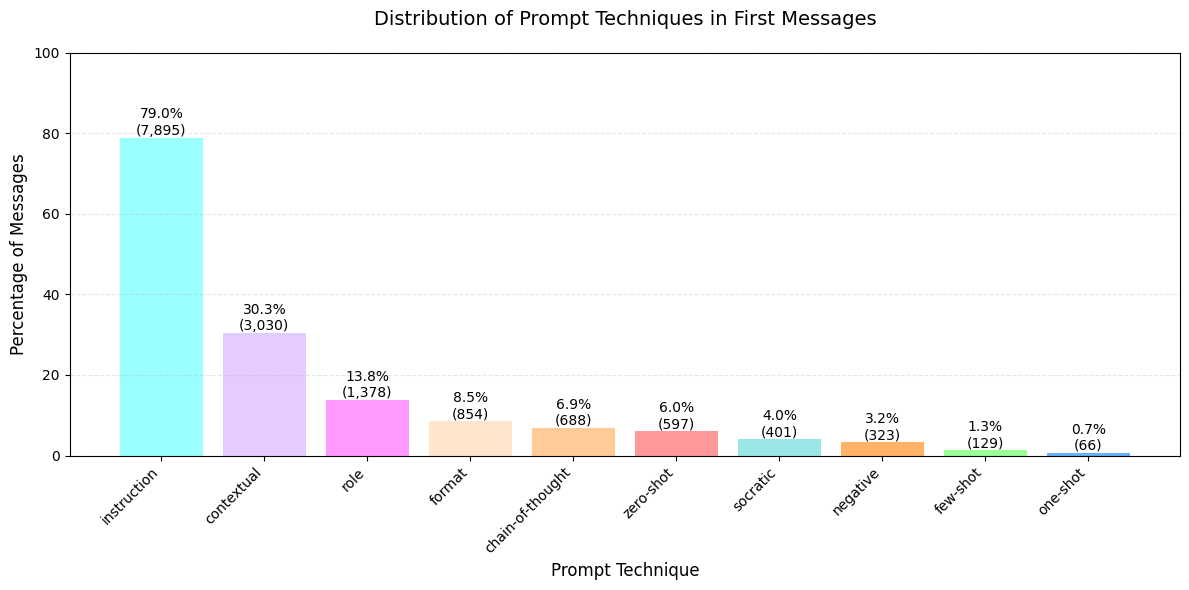

In [101]:
def create_technique_color_mapping():
    technique_colors = {
        "zero-shot": "#FF9999",
        "one-shot": "#66B2FF",
        "few-shot": "#99FF99",
        "chain-of-thought": "#FFCC99",
        "role": "#FF99FF",
        "instruction": "#99FFFF",
        "format": "#FFE5CC",
        "contextual": "#E5CCFF",
        "negative": "#FFB366",
        "socratic": "#99E6E6",
    }
    return technique_colors


valid_techniques_color_mapping = {
    "zero-shot": "#FF9999",
    "one-shot": "#66B2FF",
    "few-shot": "#99FF99",
    "chain-of-thought": "#FFCC99",
    "role": "#FF99FF",
    "instruction": "#99FFFF",
    "format": "#FFE5CC",
    "contextual": "#E5CCFF",
    "negative": "#FFB366",
    "socratic": "#99E6E6",
}

valid_techniques = valid_techniques_color_mapping.keys()


def plot_technique_distribution(techniques_df):
    all_techniques = [
        technique
        for techniques in techniques_df["techniques"]
        if isinstance(techniques, list)
        for technique in techniques
        if technique in valid_techniques
    ]

    technique_counts = pd.Series(all_techniques).value_counts()
    total_messages = len(techniques_df)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(
        range(len(technique_counts)),
        technique_counts.values / total_messages * 100,
        color=[
            valid_techniques_color_mapping[technique]
            for technique in technique_counts.index
        ],
    )

    plt.title(
        "Distribution of Prompt Techniques in First Messages", fontsize=14, pad=20
    )
    plt.ylabel("Percentage of Messages", fontsize=12)
    plt.xlabel("Prompt Technique", fontsize=12)

    plt.xticks(
        range(len(technique_counts)), technique_counts.index, rotation=45, ha="right"
    )

    for bar in bars:
        height = bar.get_height()
        count = int(height * total_messages / 100)
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.1f}%\n({count:,})",
            ha="center",
            va="bottom",
        )

    plt.ylim(0, 100)
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_technique_distribution(techniques_df)

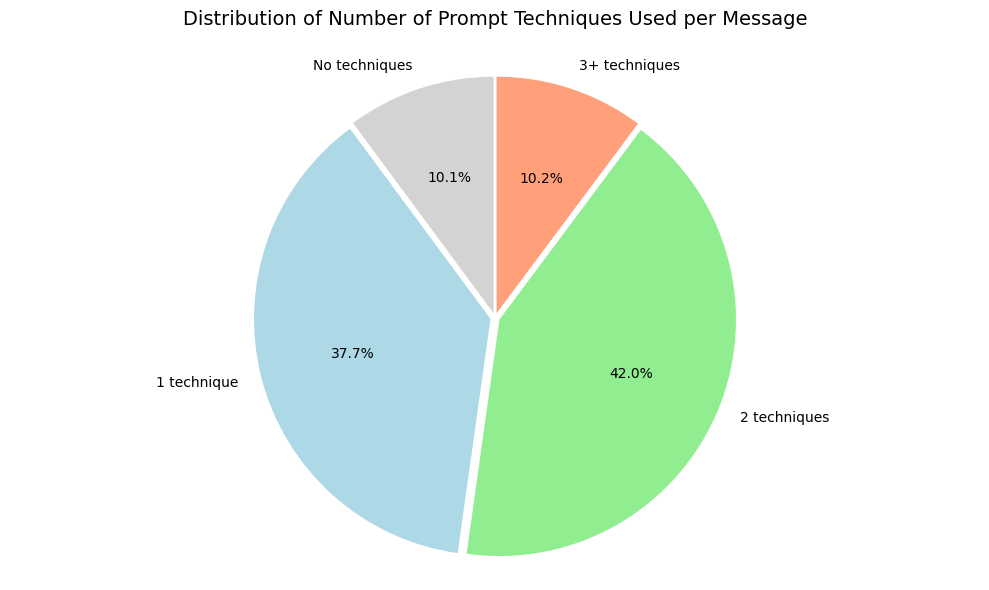

In [107]:
def plot_technique_count_distribution(techniques_df):
    technique_counts = techniques_df["techniques"].apply(
        lambda x: len(x) if isinstance(x, list) else 0
    )
    count_categories = pd.cut(
        technique_counts,
        bins=[-float("inf"), 0, 1, 2, float("inf")],
        labels=["No techniques", "1 technique", "2 techniques", "3+ techniques"],
    )

    count_distribution = count_categories.value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    plt.pie(
        count_distribution.values,
        labels=count_distribution.index,
        autopct="%1.1f%%",
        startangle=90,
        colors=["lightgray", "lightblue", "lightgreen", "lightsalmon"],
        explode=[0.02] * len(count_distribution),
    )

    plt.title(
        "Distribution of Number of Prompt Techniques Used per Message",
        fontsize=14,
        pad=20,
    )
    plt.axis("equal")

    plt.tight_layout()
    plt.show()


plot_technique_count_distribution(techniques_df)

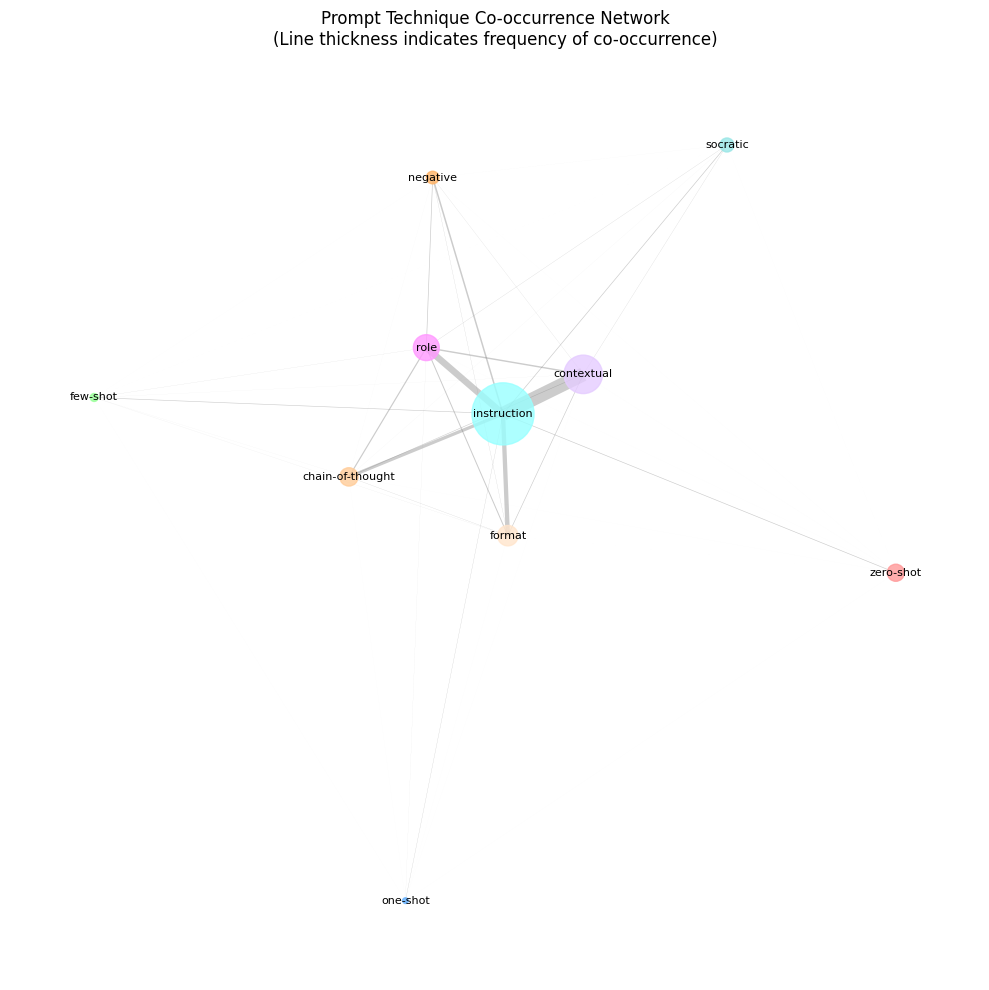


Most common prompt technique pairs:
contextual + instruction: 2760 times
instruction + role: 1298 times
format + instruction: 852 times
chain-of-thought + instruction: 637 times
instruction + negative: 299 times


In [123]:
import networkx as nx


def create_technique_network(techniques_df):
    G = nx.Graph()
    co_occurrences = {}

    for techniques in techniques_df["techniques"]:
        if not isinstance(techniques, list) or len(techniques) < 2:
            continue
        techniques = [tech for tech in techniques if tech in valid_techniques]
        for i in range(len(techniques)):
            for j in range(i + 1, len(techniques)):
                pair = tuple(sorted([techniques[i], techniques[j]]))
                co_occurrences[pair] = co_occurrences.get(pair, 0) + 1

    if not co_occurrences:
        print("No valid technique pairs found.")
        return

    max_weight = max(co_occurrences.values())
    for (tech1, tech2), weight in co_occurrences.items():
        normalized_weight = (weight / max_weight) * 10
        G.add_edge(tech1, tech2, weight=normalized_weight)

    node_sizes = {}
    for techniques in techniques_df["techniques"]:
        if not isinstance(techniques, list):
            continue
        for tech in techniques:
            if tech in valid_techniques:
                node_sizes[tech] = node_sizes.get(tech, 0) + 1

    plt.figure(figsize=(10, 10))

    pos = nx.spring_layout(G, k=0.5, iterations=50)

    edges = G.edges(data=True)
    weights = [d["weight"] for (u, v, d) in edges]
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.4, edge_color="gray")

    max_size = max(node_sizes.values())
    node_list = list(G.nodes())
    node_sizes_normalized = [
        node_sizes.get(node, 0) / max_size * 2000 for node in node_list
    ]  # Reduced max size
    node_colors = [valid_techniques_color_mapping[node] for node in node_list]

    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes_normalized,
        node_color=node_colors,
        alpha=0.8,
    )

    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(
        "Prompt Technique Co-occurrence Network\n(Line thickness indicates frequency of co-occurrence)",
        fontsize=12,
        pad=15,
    )
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    print("\nMost common prompt technique pairs:")
    top_pairs = sorted(co_occurrences.items(), key=lambda x: x[1], reverse=True)[:5]
    for (tech1, tech2), count in top_pairs:
        print(f"{tech1} + {tech2}: {count} times")


create_technique_network(techniques_df)

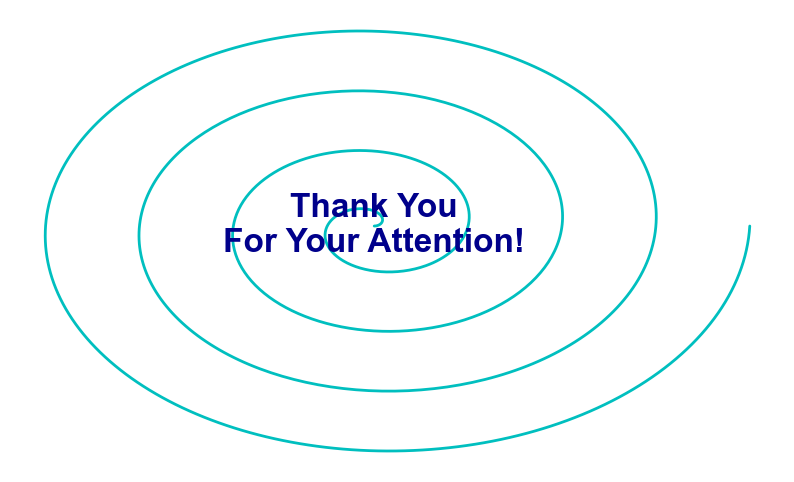

In [391]:
theta = np.linspace(0, 8 * np.pi, 1000)
r = np.linspace(0, 1, 1000)
x = r * np.cos(theta)
y = r * np.sin(theta)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, color="c", linewidth=2)

ax.text(
    0,
    0,
    "Thank You\nFor Your Attention!",
    fontsize=24,
    color="darkblue",
    fontweight="bold",
    ha="center",
    va="center",
)

ax.set_facecolor("lavender")
ax.axis("off")

plt.show()